In [2]:
#Import libraries


import random
import scanpy as sc
import scvi
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import squidpy as sq
from pathlib import Path

random.seed(10)

In [11]:
#GFAP marker genes, double check annotation and marker genes. 

#Find different cell types populations, Allen brain map. Maybe check the subtypes and see if you can find it expressed somewhere in the cell

#If you are doing DA/DE you can do GO analysis. Choose cell type and see whats the sus with it. 

#Trajectory -> GO -> DE

#https://scanpy.readthedocs.io/en/latest/tutorials.html#trajectory-inference

#Maybe check the differences between populations ))) Dont use mouse! hehe

#Oligo - N
#Astro - R
#Micrto - M

In [2]:
#os.chdir('/vsc-hard-mounts/leuven-data/338/vsc33876/IBP_Stein_2022/Data/')

In [3]:
adata_full = sc.read_h5ad('IBP_file.h5ad')

In [4]:
#Create a new annData with the oligo subcluster

adata = adata_full[adata_full.obs.celltype == 'ASC']

## Preprocessing and Visualization


In [4]:
adata.obs

Sample.ID  Batch Sex  Age Diagnosis    UMAP_1  \
AACAAGAAGCGCTGAA-1    Sample-19      3   F   90        AD -0.927257   
AACAGGGGTATCAGGG-1    Sample-19      3   F   90        AD  1.397939   
AACCATGTCCCTGTTG-1    Sample-19      3   F   90        AD  0.536977   
AACCCAAAGCCAAGGT-1    Sample-19      3   F   90        AD -0.212551   
AACGGGACAAGCTCTA-1    Sample-19      3   F   90        AD  1.041217   
...                         ...    ...  ..  ...       ...       ...   
TTGCGTCGTCCGAAAG-16  Sample-100      1   M   79   Control  1.119981   
TTGCGTCTCGAGCCAC-16  Sample-100      1   M   79   Control  1.102711   
TTGGGCGCAAAGTGTA-16  Sample-100      1   M   79   Control -0.001663   
TTGTGTTCAAGTATAG-16  Sample-100      1   M   79   Control  1.073433   
TTTAGTCGTCCTACGG-16  Sample-100      1   M   79   Control  1.866180   

                        UMAP_2 cluster celltype  
AACAAGAAGCGCTGAA-1  -12.607031    ASC3      ASC  
AACAGGGGTATCAGGG-1  -13.045775    ASC1      ASC  
AACCATGTCCCTGTTG-1  -12.958389    ASC3      ASC  
AACCCAAAGCCAAGGT-1  -12.917456    ASC3      ASC  
AACGGGACAAGCTCTA-1  -13.075922    ASC3      ASC  
...                        ...     ...      ...  
TTGCGTCGTCCGAAAG-16 -11.742434    ASC1      ASC  
TTGCGTCTCGAGCCAC-16  -9.444119    ASC1      ASC  
TTGGGCGCAAAGTGTA-16  -9.382794    ASC4      ASC  
TTGTGTTCAAGTATAG-16 -11.324558    ASC1      ASC  
TTTAGTCGTCCTACGG-16 -11.134185    ASC1      ASC  

[4756 rows x 9 columns]

In [5]:
adata.var['mt'] = adata.var.index.str.startswith('MT-')
adata.var['mt']

/tmp/ipykernel_22318/1679961783.py:1: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['mt'] = adata.var.index.str.startswith('MT-')


WASH7P        False
AL627309.1    False
CICP27        False
AL627309.6    False
AL627309.7    False
              ...  
LLPHP2        False
Z73417.1      False
ASS1P5        False
ACTRT1        False
ETDB          False
Name: mt, Length: 36114, dtype: bool

In [6]:
ribo_url = "http://software.broadinstitute.org/gsea/msigdb/download_geneset.jsp?geneSetName=KEGG_RIBOSOME&fileType=txt"
ribo_genes = pd.read_table(ribo_url, skiprows=2, header = None)
adata.var['ribo'] = adata.var_names.isin(ribo_genes[0].values)
adata.var['ribo']

WASH7P        False
AL627309.1    False
CICP27        False
AL627309.6    False
AL627309.7    False
              ...  
LLPHP2        False
Z73417.1      False
ASS1P5        False
ACTRT1        False
ETDB          False
Name: ribo, Length: 36114, dtype: bool

In [7]:
#Calculate QC metrics, controlling for ribo and mito

sc.pp.calculate_qc_metrics(adata, qc_vars=['mt', 'ribo'], percent_top=None, log1p=False, inplace=True)

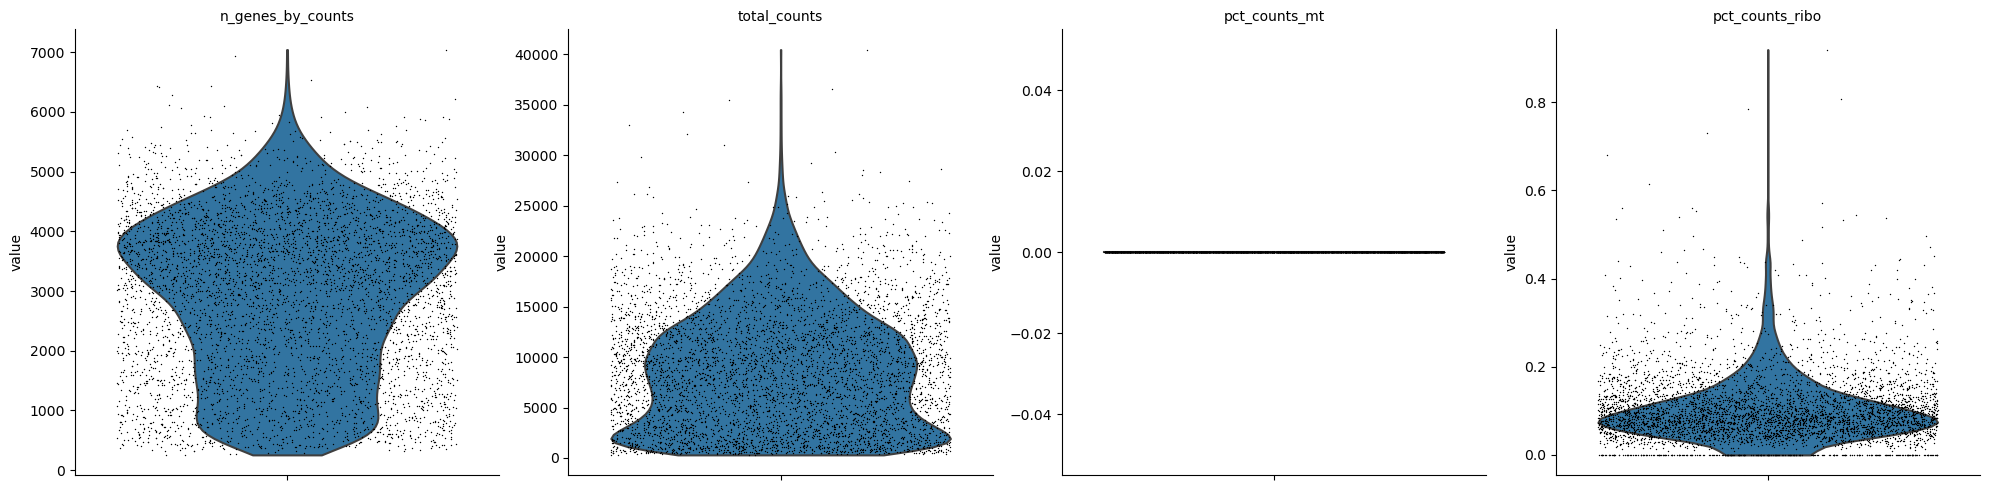

In [8]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo'], 
             jitter=0.4, multi_panel=True)

/tmp/ipykernel_22318/2961596687.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(
/tmp/ipykernel_22318/2961596687.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(


<AxesSubplot:xlabel='n_genes_by_counts'>

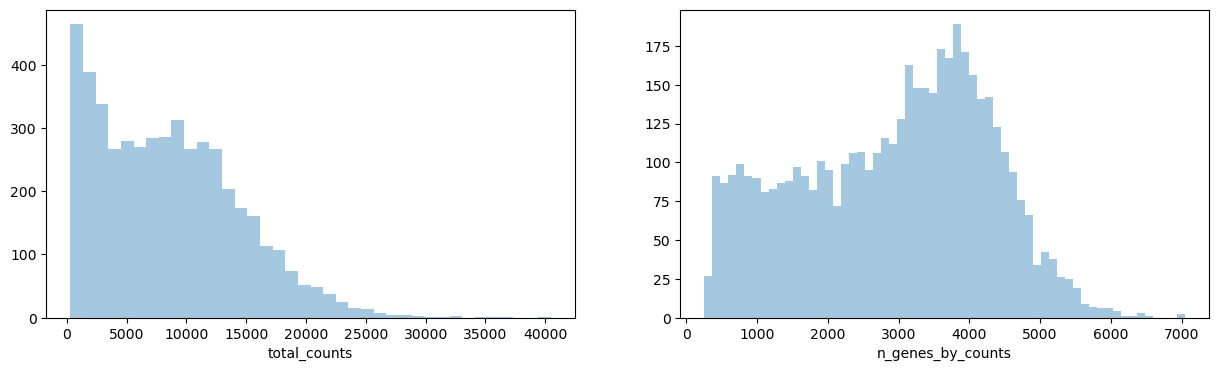

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(15, 4))
sns.distplot(
    adata.obs["total_counts"],
    kde=False,
    ax=axs[0],
)
sns.distplot(
    adata.obs["n_genes_by_counts"],
    kde=False,
    bins=60,
    ax=axs[1],
)

In [10]:
adata.var.sort_values('n_cells_by_counts')

mt   ribo  n_cells_by_counts  mean_counts  \
ETDB        False  False                  0     0.000000   
LINC01849   False  False                  0     0.000000   
AC005383.1  False  False                  0     0.000000   
NTAN1P1     False  False                  0     0.000000   
AC012493.2  False  False                  0     0.000000   
...           ...    ...                ...          ...   
NRG3        False  False               4698    47.223927   
LSAMP       False  False               4698    73.514931   
NPAS3       False  False               4705    55.785534   
PCDH9       False  False               4726    68.831161   
MALAT1      False  False               4756   470.501038   

            pct_dropout_by_counts  total_counts  
ETDB                   100.000000           0.0  
LINC01849              100.000000           0.0  
AC005383.1             100.000000           0.0  
NTAN1P1                100.000000           0.0  
AC012493.2             100.000000           0.0  
...                           ...           ...  
NRG3                     1.219512      224597.0  
LSAMP                    1.219512      349637.0  
NPAS3                    1.072330      265316.0  
PCDH9                    0.630782      327361.0  
MALAT1                   0.000000     2237703.0  

[36114 rows x 6 columns]

In [11]:
adata.obs.sort_values('n_genes_by_counts')


Sample.ID  Batch Sex  Age Diagnosis    UMAP_1  \
TCACTCGCAGCTCCTT-8    Sample-52      3   M   83   Control -1.640575   
CACGTGGAGGCTCATC-2    Sample-43      1   F   90        AD  1.182814   
ATCAGGTTCCTTCTTC-14   Sample-82      2   M   79   Control  0.983047   
GAGACCCGTTTCGCTC-14   Sample-82      2   M   79   Control  1.090765   
TAGAGTCTCAAATGAG-14   Sample-82      2   M   79   Control  1.035171   
...                         ...    ...  ..  ...       ...       ...   
ATCACTTGTGTCCAAT-9    Sample-96      1   M   79   Control  0.877501   
GCAACATAGTATGTAG-5    Sample-27      2   M   81        AD  1.136022   
TCAGTCCCATCATCCC-16  Sample-100      1   M   79   Control  1.661414   
TTCTTCCAGGTCGCCT-9    Sample-96      1   M   79   Control  1.427009   
TCACTCGCAGCTCCTT-4    Sample-22      2   M   86        AD  0.818545   

                        UMAP_2 cluster celltype  n_genes_by_counts  \
TCACTCGCAGCTCCTT-8  -14.278470    ASC2      ASC                255   
CACGTGGAGGCTCATC-2  -15.597982    ASC2      ASC                258   
ATCAGGTTCCTTCTTC-14  -9.309150    ASC1      ASC                263   
GAGACCCGTTTCGCTC-14  -9.547157    ASC1      ASC                276   
TAGAGTCTCAAATGAG-14  -9.162514    ASC1      ASC                282   
...                        ...     ...      ...                ...   
ATCACTTGTGTCCAAT-9  -11.958054    ASC1      ASC               6434   
GCAACATAGTATGTAG-5  -10.188618    ASC1      ASC               6440   
TCAGTCCCATCATCCC-16 -10.401897    ASC1      ASC               6536   
TTCTTCCAGGTCGCCT-9  -11.047528    ASC1      ASC               6939   
TCACTCGCAGCTCCTT-4  -12.808661    ASC1      ASC               7045   

                     total_counts  total_counts_mt  pct_counts_mt  \
TCACTCGCAGCTCCTT-8          307.0              0.0            0.0   
CACGTGGAGGCTCATC-2          320.0              0.0            0.0   
ATCAGGTTCCTTCTTC-14         315.0              0.0            0.0   
GAGACCCGTTTCGCTC-14         320.0              0.0            0.0   
TAGAGTCTCAAATGAG-14         352.0              0.0            0.0   
...                           ...              ...            ...   
ATCACTTGTGTCCAAT-9        30988.0              0.0            0.0   
GCAACATAGTATGTAG-5        25888.0              0.0            0.0   
TCAGTCCCATCATCCC-16       32974.0              0.0            0.0   
TTCTTCCAGGTCGCCT-9        36550.0              0.0            0.0   
TCACTCGCAGCTCCTT-4        40457.0              0.0            0.0   

                     total_counts_ribo  pct_counts_ribo  
TCACTCGCAGCTCCTT-8                 0.0         0.000000  
CACGTGGAGGCTCATC-2                 1.0         0.312500  
ATCAGGTTCCTTCTTC-14                0.0         0.000000  
GAGACCCGTTTCGCTC-14                0.0         0.000000  
TAGAGTCTCAAATGAG-14                0.0         0.000000  
...                                ...              ...  
ATCACTTGTGTCCAAT-9                39.0         0.125855  
GCAACATAGTATGTAG-5                34.0         0.131335  
TCAGTCCCATCATCCC-16               26.0         0.078850  
TTCTTCCAGGTCGCCT-9                28.0         0.076607  
TCACTCGCAGCTCCTT-4                25.0         0.061794  

[4756 rows x 15 columns]

In [12]:
sc.pp.filter_cells(adata, min_genes=500)
sc.pp.filter_genes(adata, min_cells=20)

In [13]:
sc.pp.normalize_total(adata, target_sum=1e4) #normalize every cell to 10,000 UMI. Can be anything else

In [14]:
adata.X.sum(axis = 1)

matrix([[ 9999.999],
        [ 9999.999],
        [10000.   ],
        ...,
        [10000.001],
        [10000.   ],
        [10000.   ]], dtype=float32)

In [15]:
sc.pp.log1p(adata) #change to log counts

In [16]:
adata.X.sum(axis = 1)

matrix([[3848.5322],
        [3623.6055],
        [4263.293 ],
        ...,
        [3796.7183],
        [3554.0972],
        [3847.5142]], dtype=float32)

In [17]:
adata.raw = adata

## Clustering

In [18]:
sc.pp.highly_variable_genes(adata, n_top_genes = 5000)

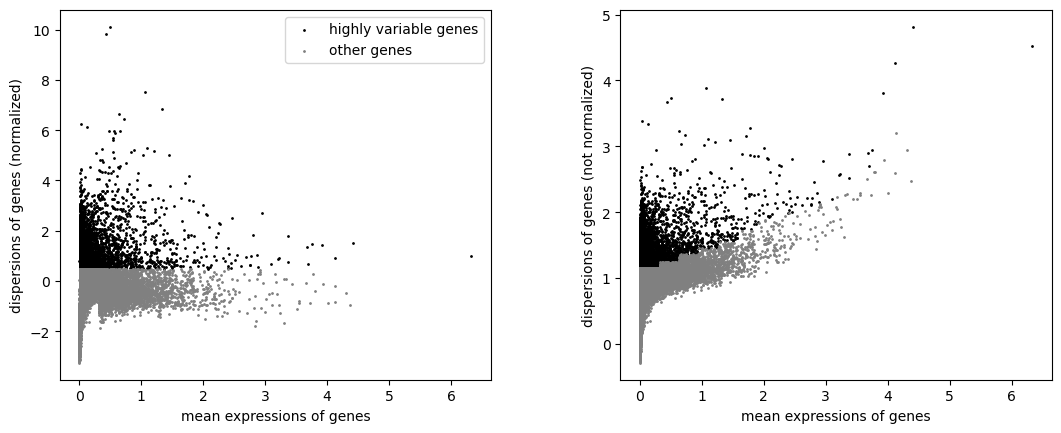

In [19]:
sc.pl.highly_variable_genes(adata)

In [20]:
adata = adata[:, adata.var.highly_variable]

In [21]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_ribo'])

In [22]:
sc.pp.scale(adata, max_value=10)

In [23]:
sc.tl.pca(adata)

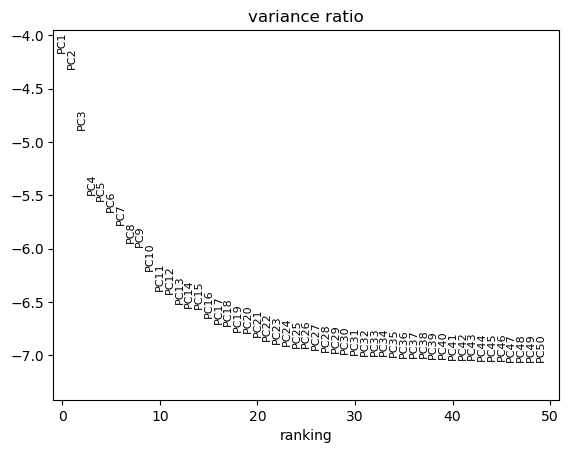

In [24]:
sc.pl.pca_variance_ratio(adata, log=True, n_pcs = 50) #Plotting all PCs 

In [25]:
sc.pp.neighbors(adata, n_pcs = 35)

/home/rucs/miniconda3/envs/scenicplus/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 10006. The TBB threading layer is disabled.
  warnings.warn(problem)
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [26]:
sc.tl.draw_graph(adata)

In [27]:
adata.obs

Sample.ID  Batch Sex  Age Diagnosis    UMAP_1  \
AACAAGAAGCGCTGAA-1    Sample-19      3   F   90        AD -0.927257   
AACAGGGGTATCAGGG-1    Sample-19      3   F   90        AD  1.397939   
AACCATGTCCCTGTTG-1    Sample-19      3   F   90        AD  0.536977   
AACCCAAAGCCAAGGT-1    Sample-19      3   F   90        AD -0.212551   
AACGGGACAAGCTCTA-1    Sample-19      3   F   90        AD  1.041217   
...                         ...    ...  ..  ...       ...       ...   
TTGCGTCGTCCGAAAG-16  Sample-100      1   M   79   Control  1.119981   
TTGCGTCTCGAGCCAC-16  Sample-100      1   M   79   Control  1.102711   
TTGGGCGCAAAGTGTA-16  Sample-100      1   M   79   Control -0.001663   
TTGTGTTCAAGTATAG-16  Sample-100      1   M   79   Control  1.073433   
TTTAGTCGTCCTACGG-16  Sample-100      1   M   79   Control  1.866180   

                        UMAP_2 cluster celltype  n_genes_by_counts  \
AACAAGAAGCGCTGAA-1  -12.607031    ASC3      ASC               4191   
AACAGGGGTATCAGGG-1  -13.045775    ASC1      ASC               3403   
AACCATGTCCCTGTTG-1  -12.958389    ASC3      ASC               4817   
AACCCAAAGCCAAGGT-1  -12.917456    ASC3      ASC               4082   
AACGGGACAAGCTCTA-1  -13.075922    ASC3      ASC               3503   
...                        ...     ...      ...                ...   
TTGCGTCGTCCGAAAG-16 -11.742434    ASC1      ASC               2375   
TTGCGTCTCGAGCCAC-16  -9.444119    ASC1      ASC               3420   
TTGGGCGCAAAGTGTA-16  -9.382794    ASC4      ASC               3462   
TTGTGTTCAAGTATAG-16 -11.324558    ASC1      ASC               2841   
TTTAGTCGTCCTACGG-16 -11.134185    ASC1      ASC               3918   

                     total_counts  total_counts_mt  pct_counts_mt  \
AACAAGAAGCGCTGAA-1        12933.0              0.0            0.0   
AACAGGGGTATCAGGG-1         9806.0              0.0            0.0   
AACCATGTCCCTGTTG-1        14414.0              0.0            0.0   
AACCCAAAGCCAAGGT-1        14707.0              0.0            0.0   
AACGGGACAAGCTCTA-1         9783.0              0.0            0.0   
...                           ...              ...            ...   
TTGCGTCGTCCGAAAG-16        5180.0              0.0            0.0   
TTGCGTCTCGAGCCAC-16        9402.0              0.0            0.0   
TTGGGCGCAAAGTGTA-16        8749.0              0.0            0.0   
TTGTGTTCAAGTATAG-16        6500.0              0.0            0.0   
TTTAGTCGTCCTACGG-16       11576.0              0.0            0.0   

                     total_counts_ribo  pct_counts_ribo  n_genes  
AACAAGAAGCGCTGAA-1                12.0         0.092786     4191  
AACAGGGGTATCAGGG-1                 6.0         0.061187     3403  
AACCATGTCCCTGTTG-1                13.0         0.090190     4817  
AACCCAAAGCCAAGGT-1                11.0         0.074794     4082  
AACGGGACAAGCTCTA-1                11.0         0.112440     3503  
...                                ...              ...      ...  
TTGCGTCGTCCGAAAG-16               12.0         0.231660     2375  
TTGCGTCTCGAGCCAC-16               20.0         0.212721     3420  
TTGGGCGCAAAGTGTA-16               14.0         0.160018     3462  
TTGTGTTCAAGTATAG-16                8.0         0.123077     2841  
TTTAGTCGTCCTACGG-16               21.0         0.181410     3918  

[4626 rows x 16 columns]

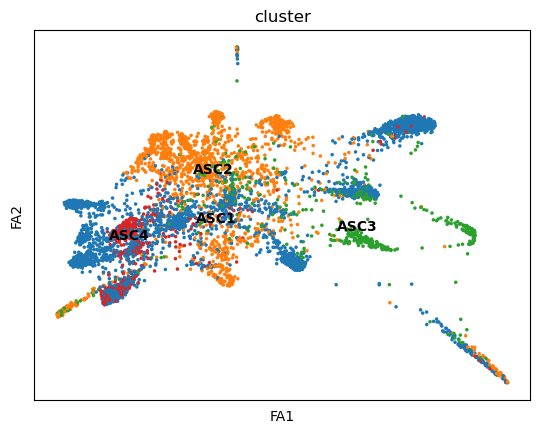

In [28]:
sc.pl.draw_graph(adata, color='cluster', legend_loc='on data')

## Batch Correction with SCVI

In [64]:
import scvi
import scanpy as sc
import matplotlib.pyplot as plt

sc.set_figure_params(figsize=(4, 4))

In [65]:
#os.chdir('/vsc-hard-mounts/leuven-data/338/vsc33876/IBP_Stein_2022/Data/')

In [66]:
adata_full = sc.read_h5ad('IBP_file.h5ad')

In [67]:
adata = adata_full[adata_full.obs.celltype == 'ASC']

In [68]:
adata.var['mt'] = adata.var.index.str.startswith('MT-')
ribo_url = "http://software.broadinstitute.org/gsea/msigdb/download_geneset.jsp?geneSetName=KEGG_RIBOSOME&fileType=txt"
ribo_genes = pd.read_table(ribo_url, skiprows=2, header = None)
adata.var['ribo'] = adata.var_names.isin(ribo_genes[0].values)
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt', 'ribo'], percent_top=None, log1p=False, inplace=True)
sc.pp.filter_cells(adata, min_genes=500)
sc.pp.filter_genes(adata, min_cells=20)

/tmp/ipykernel_22318/3716145390.py:1: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['mt'] = adata.var.index.str.startswith('MT-')


In [69]:
adata.layers["counts"] = adata.X.copy() # preserve counts
sc.pp.normalize_total(adata, target_sum=1e4) #normalize every cell to 10,000 UMI. Can be anything else

In [70]:
sc.pp.log1p(adata) #change to log counts

In [71]:
adata.raw = adata

In [72]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=5000,
    subset=True,
    layer="counts",
    batch_key="Sample.ID"
)

/home/rucs/miniconda3/envs/scenicplus/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:475: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/home/rucs/miniconda3/envs/scenicplus/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:475: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/home/rucs/miniconda3/envs/scenicplus/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:475: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/home/rucs/miniconda3/envs/scenicplus/lib/python3.8/site-packages/scanpy/preprocessing/_highly

In [73]:
adata

AnnData object with n_obs × n_vars = 4626 × 5000
    obs: 'Sample.ID', 'Batch', 'Sex', 'Age', 'Diagnosis', 'UMAP_1', 'UMAP_2', 'cluster', 'celltype', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'n_genes'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg'
    layers: 'counts'

In [74]:
adata.obs.rename(columns={"Sample.ID": "SampleID"}, inplace=True)
adata

AnnData object with n_obs × n_vars = 4626 × 5000
    obs: 'SampleID', 'Batch', 'Sex', 'Age', 'Diagnosis', 'UMAP_1', 'UMAP_2', 'cluster', 'celltype', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'n_genes'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg'
    layers: 'counts'

In [ ]:
#DO NOT DO
scvi.model.SCVI.setup_anndata(
    adata,
    layer="counts",
    categorical_covariate_keys=["SampleID", "Batch"],
    continuous_covariate_keys=["pct_counts_mt", "pct_counts_ribo"]
)

In [27]:
model

SCVI Model with the following params: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, 
gene_likelihood: zinb, latent_distribution: normal
Training status: Not Trained

In [28]:
#DO NOT DO
model.train()

/data/leuven/338/vsc33876/miniconda3/envs/python38/lib/python3.8/site-packages/scvi/model/base/_training_mixin.py:67: UserWarning: max_epochs=216 is less than n_epochs_kl_warmup=400. The max_kl_weight will not be reached during training.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 2/216:   0%|▏                                         | 1/216 [08:31<30:31:20, 511.07s/it, loss=2.02e+03, v_num=1]

/data/leuven/338/vsc33876/miniconda3/envs/python38/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:653: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [ ]:
#DO NOT DO
model.save("my_oligo_model")

In [75]:
model = scvi.model.SCVI.load("astrocyte_model/", adata=adata, use_gpu=False)

INFO     File astrocyte_model/model.pt already downloaded                                    


#### Obtaining model outputs

In [76]:
latent = model.get_latent_representation()

In [77]:
adata.obsm["X_scVI"] = latent

In [78]:
adata.layers["scvi_normalized"] = model.get_normalized_expression(
    library_size=10e4
)

In [79]:
# use scVI latent space for UMAP generation
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata)

In [80]:
sc.tl.umap(adata, min_dist=0.3)

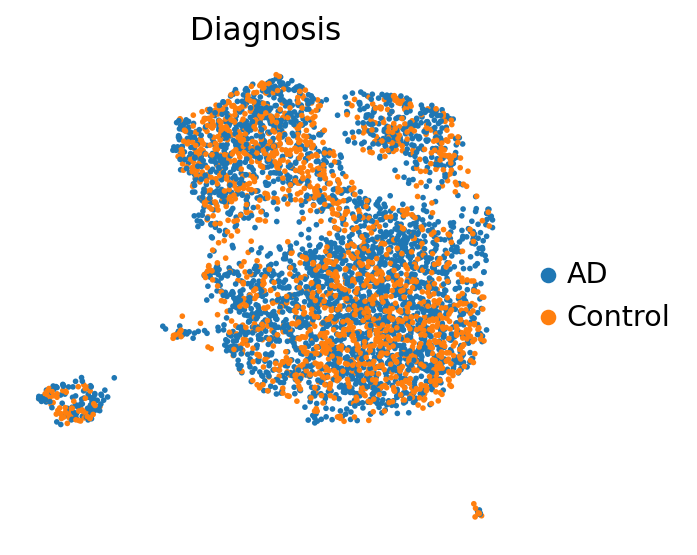

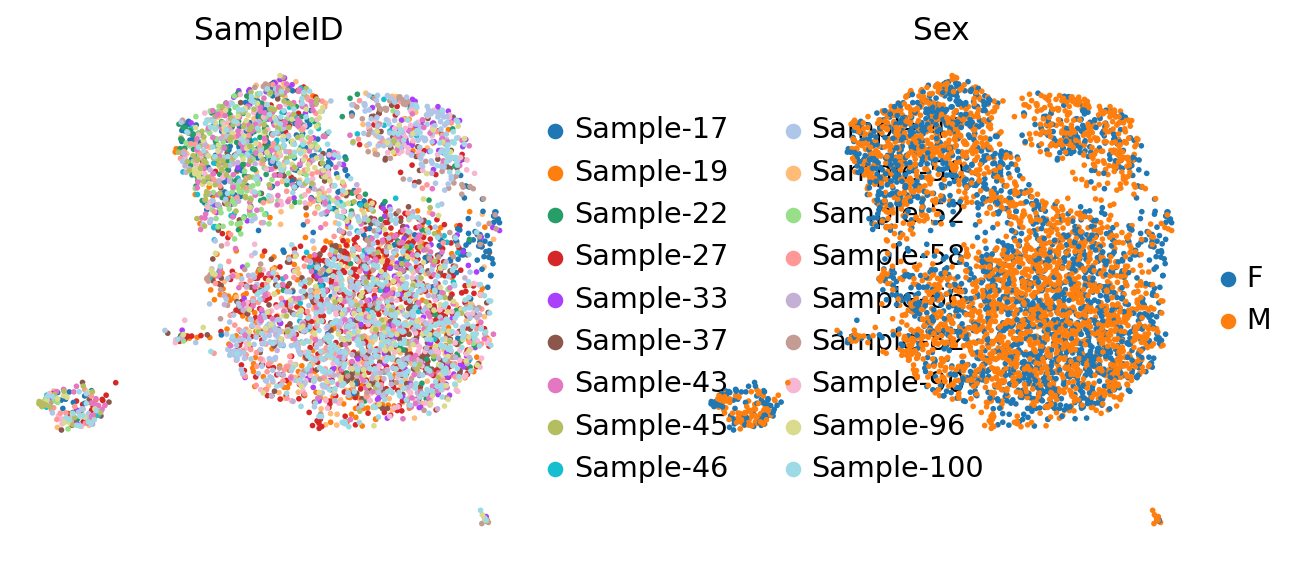

In [81]:
sc.pl.umap(
    adata,
    color=["Diagnosis"],
    frameon=False,
)
sc.pl.umap(
    adata,
    color=["SampleID", "Sex"],
    ncols=2,
    frameon=False,
)

In [82]:
sc.tl.leiden(adata, resolution = 0.7, key_added='leiden07') 

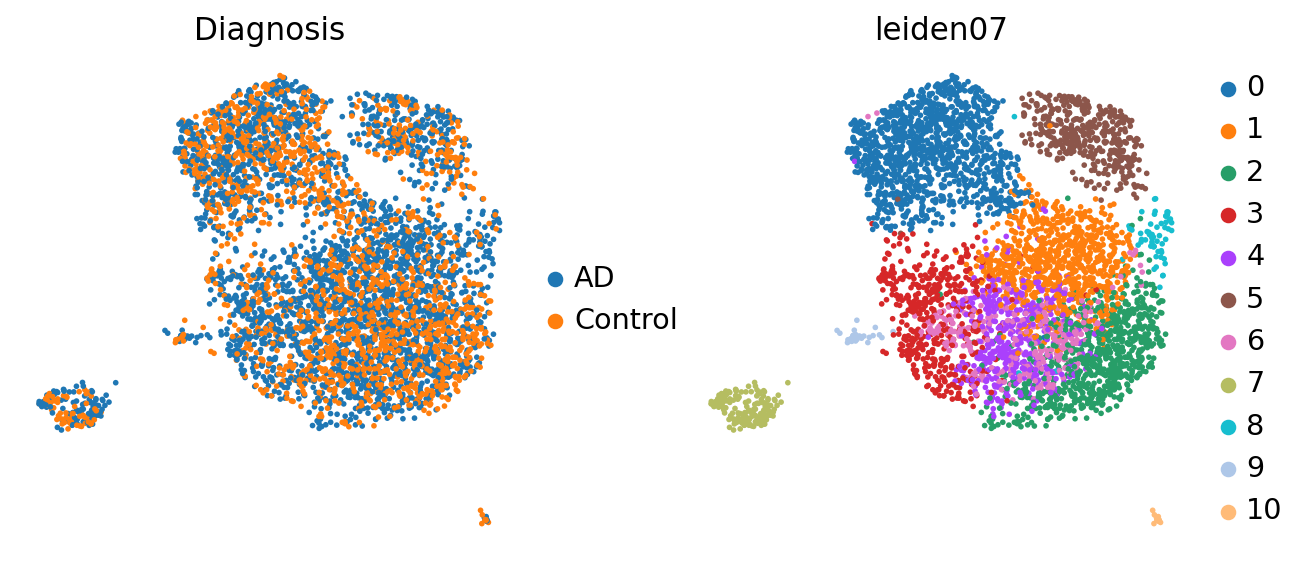

In [83]:
sc.pl.umap(
    adata,
    color=["Diagnosis", "leiden07"],
    ncols=2,
    frameon=False,
)

In [84]:
adata.write("astro_SCVI.h5ad")

In [6]:
adata = sc.read_h5ad('/vsc-hard-mounts/leuven-data/338/vsc33876/IBP_Stein_2022/Data/Oligo_SCVI.h5ad')

## Batch Correction Samples with Harmony

In [29]:
from harmony import harmonize

In [30]:
Z = harmonize(adata.obsm['X_pca'], adata.obs, batch_key = 'Sample.ID')
adata.obsm['X_harmony'] = Z

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7faea32dc040>
Traceback (most recent call last):
  File "/home/rucs/miniconda3/envs/scenicplus/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/rucs/miniconda3/envs/scenicplus/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/rucs/miniconda3/envs/scenicplus/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/rucs/miniconda3/envs/scenicplus/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _Th

	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
	Completed 6 / 10 iteration(s).
	Completed 7 / 10 iteration(s).
	Completed 8 / 10 iteration(s).
	Completed 9 / 10 iteration(s).
	Completed 10 / 10 iteration(s).


In [31]:
sc.pp.neighbors(adata, n_pcs = 35, use_rep = 'X_harmony')

In [32]:
sc.tl.umap(adata, init_pos = 'X_harmony')

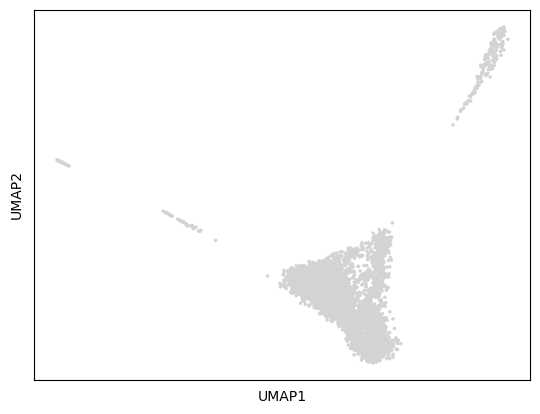

In [33]:
sc.pl.umap(adata) #empty mapping

In [34]:
sc.tl.leiden(adata, resolution = 1.0, key_added='leiden1') #0-1 from less cluters to more, can play with numbers
sc.tl.leiden(adata, resolution = 0.5, key_added='leiden05') #0-1 from less cluters to more, can play with numbers
sc.tl.leiden(adata, resolution = 0.1, key_added='leiden01') #0-1 from less cluters to more, can play with numbers
sc.tl.leiden(adata, resolution = 0.4, key_added='leiden04') #0-1 from less cluters to more, can play with numbers

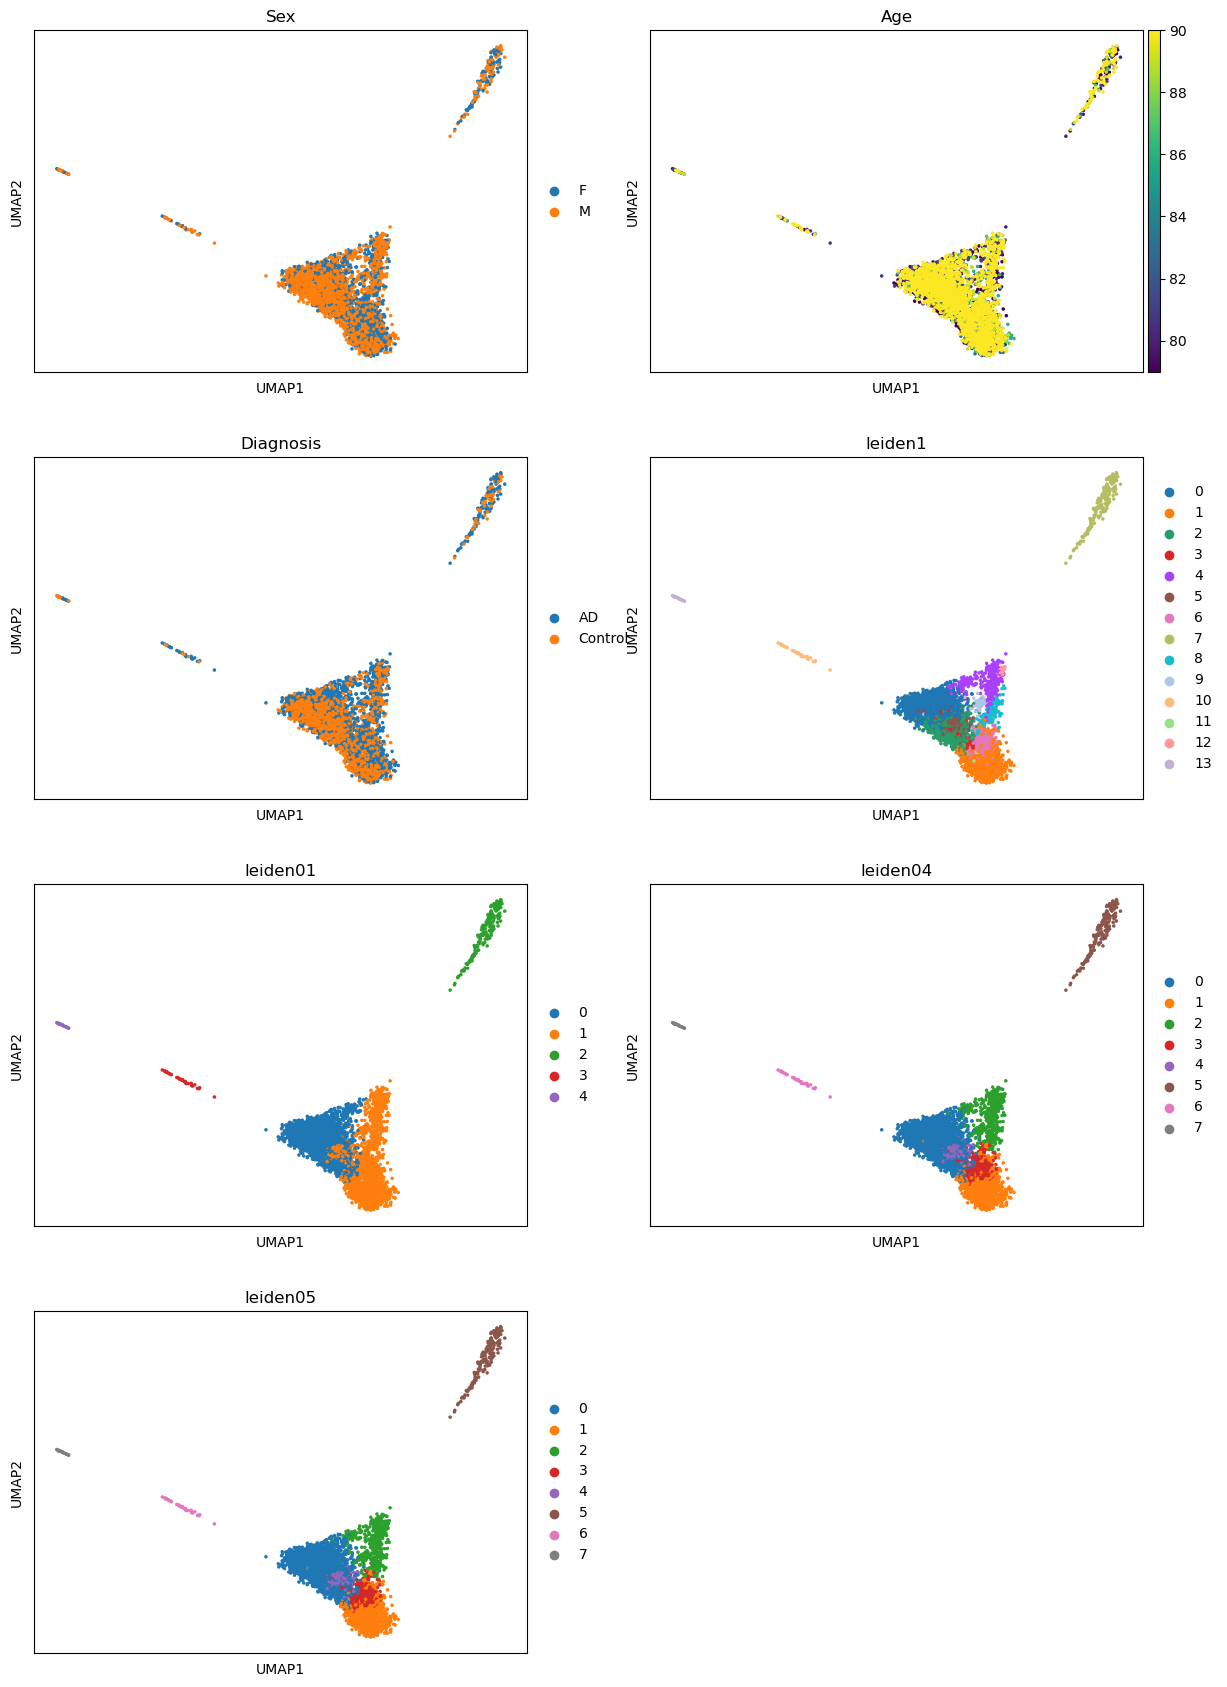

In [35]:
sc.pl.umap(adata, color= ['Sex', 'Age', 'Diagnosis', 'leiden1', 'leiden01' ,'leiden04', 'leiden05'], ncols = 2)

In [36]:
adata.write("astro_harmony.h5ad")

In [ ]:
#adata = sc.read_h5ad('Oligo_Corrected.h5ad')

#### Check if data is normalized between sex/disease/age variable with each other. How to do that? 



<AxesSubplot:xlabel='Sex', ylabel='count'>

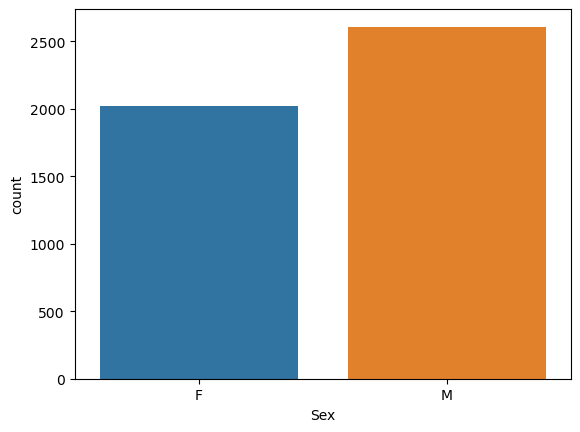

In [37]:
sns.countplot(x = adata.obs.Sex)

<AxesSubplot:xlabel='Diagnosis', ylabel='count'>

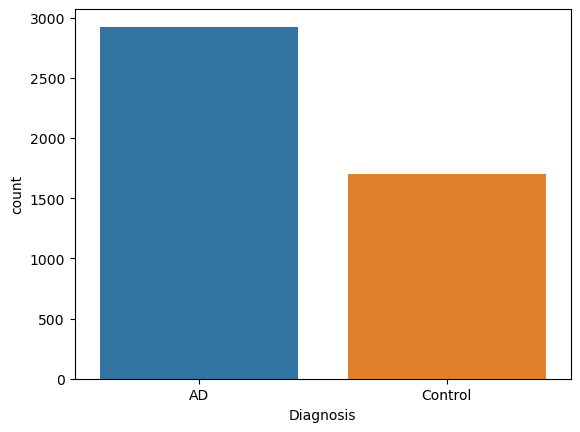

In [38]:
sns.countplot(x = adata.obs.Diagnosis)

In [39]:
sns.countplot(x = adata.obs.Age_range)

#Need to better categorize the age groups - Id say we drop it

AttributeError: 'DataFrame' object has no attribute 'Age_range'

## Denoising the graph


## Add leiden clustering (Shouldbe ignored!!!!)

/data/leuven/338/vsc33876/miniconda3/envs/python38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


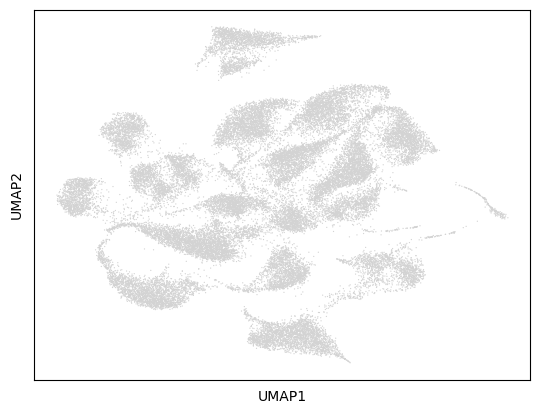

In [41]:
sc.pl.umap(adata) #empty mapping

In [40]:
sc.tl.leiden(adata, resolution = 1.0, key_added='leiden1') #0-1 from less cluters to more, can play with numbers
sc.tl.leiden(adata, resolution = 0.5, key_added='leiden05') #0-1 from less cluters to more, can play with numbers
sc.tl.leiden(adata, resolution = 0.1, key_added='leiden01') #0-1 from less cluters to more, can play with numbers
sc.tl.leiden(adata, resolution = 0.4, key_added='leiden04') #0-1 from less cluters to more, can play with numbers

## Ranked Genes

In [43]:
#Get ranked geens so we can plot them after

# sc.tl.rank_genes_groups(adata, 'leiden', use_raw = True, method = 't-test_overestim_var')

In [ ]:
# sc.pl.rank_genes_groups(adata,n_genes=20, sharey=False )

In [41]:
#Dataframe with ranked genes by clusters. Can be applied for other rankings too. Have no idea why gives errors. 

cluster_ranked_genes_l04 = pd.DataFrame()
sc.tl.rank_genes_groups(adata, groupby="leiden07", use_raw=True)
sc.pl.rank_genes_groups(adata, n_genes=10, sharey=False)
for i in range(8):
    cluster_ranked_genes_l04[i] = sc.get.rank_genes_groups_df(adata, group=str(i))[['names']]

KeyError: 'leiden07'

In [31]:
pwd

'/vsc-hard-mounts/leuven-data/338/vsc33876/IBP_Stein_2022/Data'

In [32]:
#Save for GO analysis
cluster_ranked_genes_l04.to_csv('/vsc-hard-mounts/leuven-data/338/vsc33876/IBP_Stein_2022/Data/go_oligo/clustersgenes07.csv')

In [54]:
#Dataframe with gene markers from cluster leiden 0.4

cluster_ranked_genes_l04

0          1          2        3         4          5  \
0       ADGRL3      CADM2    SLC5A11   CTNND2  IL1RAPL1    SLC5A11   
1        CADM2     ADGRL3  LINC00609      FRY    SPOCK1   ANKRD18A   
2        NLGN1      NLGN1    RASGRF1   FCHSD2     PTPRD       ST18   
3        CNDP1     FCHSD2    RASGRF2    ERBB4     PTPRM       HIP1   
4      CNTNAP2    ST3GAL6      ACTN2   KCNAB1       QKI  LINC00609   
...        ...        ...        ...      ...       ...        ...   
24175  COL18A1      SMOC1      NLGN1  SLC5A11   PLEKHG1       PLP1   
24176    ABCA6  LINC00609     CTNND2  LDLRAD3    ARPP21    LDLRAD3   
24177    PTPRM   ANKRD18A     PLXDC2    CPXM2     GRIA2    ST3GAL6   
24178     AFF3    SLC5A11      LAMA2  RASGRF1     LRP1B      LRP1B   
24179     PRKX    RASGRF2     FCHSD2  CNTNAP2    ADGRL3     ADGRL3   

                6          7  
0           PTPRM      SVEP1  
1             DCC    PPP2R2B  
2           MYRIP       ANK3  
3          SPOCK1  LINC00609  
4           TMTC2      NRXN3  
...           ...        ...  
24175       KCTD8      ABCA6  
24176      ARPP21      MDGA2  
24177  AL445250.1      ZFPM2  
24178       ABTB2    LDLRAD3  
24179      ADGRL3       ETV5  

[24180 rows x 8 columns]

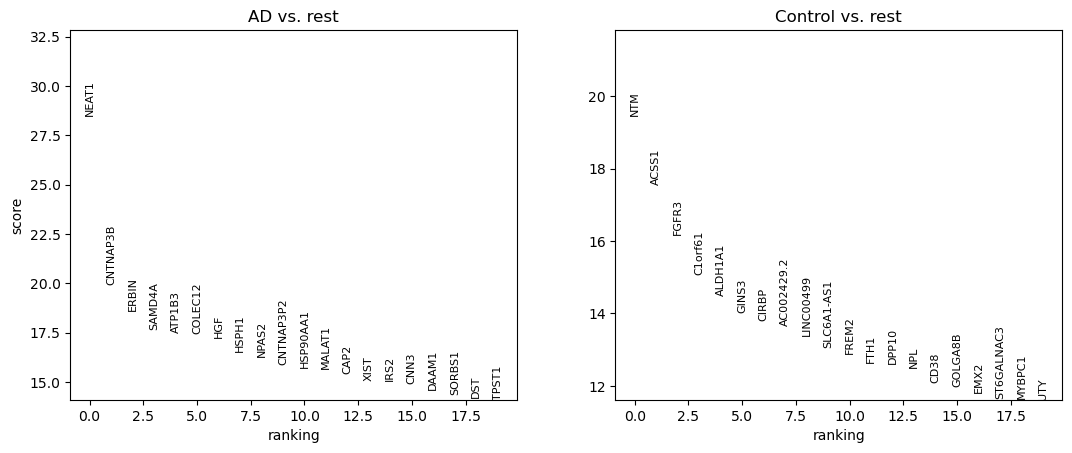

In [42]:
#Dataframe with ranked genes by Diagnosis
cluster_ranked_genes_Diag = pd.DataFrame()
sc.tl.rank_genes_groups(adata, groupby="Diagnosis", use_raw=True)
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)
cluster_ranked_genes_Diag = sc.get.rank_genes_groups_df(adata, group=None)

In [43]:
#Save AD and control genes
cluster_ranked_genes_Diag[cluster_ranked_genes_Diag['group'] == "AD"]['names'].to_csv('asc_clusterrankedgenes_AD.csv')
cluster_ranked_genes_Diag[cluster_ranked_genes_Diag['group'] == "Control"]['names'].to_csv('asc_clusterrankedgenes_control.csv')

In [44]:
#Control ranked genes:
cluster_ranked_genes_Diag[cluster_ranked_genes_Diag['group'] == "Control"]['names'].head(10)

19421           NTM
19422         ACSS1
19423         FGFR3
19424       C1orf61
19425       ALDH1A1
19426         GINS3
19427         CIRBP
19428    AC002429.2
19429     LINC00499
19430    SLC6A1-AS1
Name: names, dtype: object

In [45]:
#AD ranked genes:
cluster_ranked_genes_Diag[cluster_ranked_genes_Diag['group'] == "AD"]['names'].head(10)

0        NEAT1
1     CNTNAP3B
2        ERBIN
3       SAMD4A
4       ATP1B3
5      COLEC12
6          HGF
7        HSPH1
8        NPAS2
9    CNTNAP3P2
Name: names, dtype: object

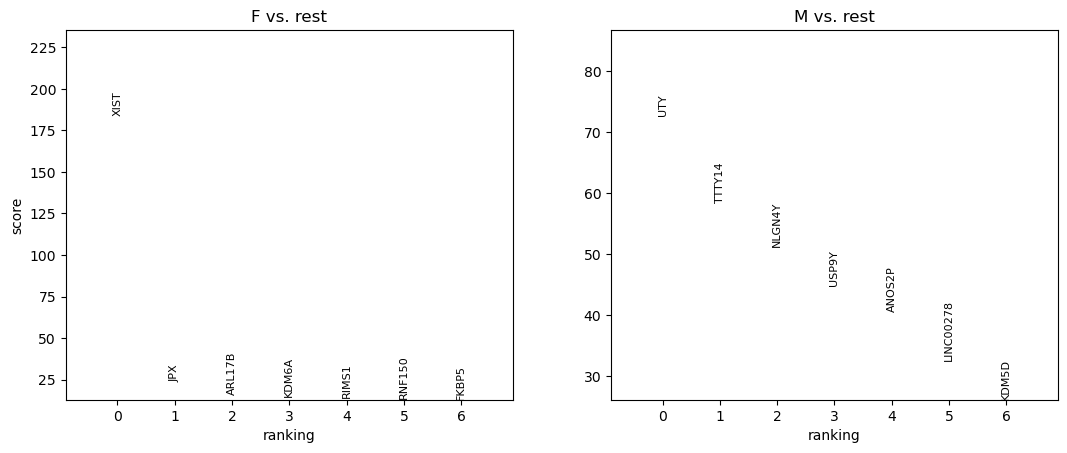

In [46]:
#Dataframe with ranked genes by Sex
cluster_ranked_genes_Sex = pd.DataFrame()
sc.tl.rank_genes_groups(adata, groupby="Sex", use_raw=True)
sc.pl.rank_genes_groups(adata, n_genes=7, sharey=False)
cluster_ranked_genes_Sex = sc.get.rank_genes_groups_df(adata, group= None)

In [47]:
#Save sex
cluster_ranked_genes_Sex[cluster_ranked_genes_Sex['group'] == "F"]['names'].to_csv('asc_female.csv')
cluster_ranked_genes_Sex[cluster_ranked_genes_Sex['group'] == "M"]['names'].to_csv('asc_male.csv')

In [48]:
# Check 10 most expressed genes for each sex:

#Female:
cluster_ranked_genes_Sex[cluster_ranked_genes_Sex['group'] == "F"]['names'].head(10)

0         XIST
1          JPX
2       ARL17B
3        KDM6A
4        RIMS1
5       RNF150
6        FKBP5
7    LINC01138
8      CCDC200
9        HIF3A
Name: names, dtype: object

In [49]:
#Male
cluster_ranked_genes_Sex[cluster_ranked_genes_Sex['group'] == "M"]['names'].head(10)

19421          UTY
19422       TTTY14
19423       NLGN4Y
19424        USP9Y
19425       ANOS2P
19426    LINC00278
19427        KDM5D
19428        DDX3Y
19429       RPS4Y1
19430       TTTY10
Name: names, dtype: object

In [50]:
#We will group the data by 3 age groups, from 79-83, 84-87, 88-90
#Can work with percetiles, or other methods maybe? 


adata.obs.sort_values(by='Age', ascending=False)

Sample.ID  Batch Sex  Age Diagnosis    UMAP_1  \
AACAAGAAGCGCTGAA-1    Sample-19      3   F   90        AD -0.927257   
GAGACTTAGATGTAGT-18   Sample-47      3   M   90        AD  1.684959   
GAAGGGTGTTATCTTC-18   Sample-47      3   M   90        AD  0.827300   
GAAGTAAGTAGTTCCA-18   Sample-47      3   M   90        AD  1.142183   
GAATCACGTGTTCATG-18   Sample-47      3   M   90        AD  0.798823   
...                         ...    ...  ..  ...       ...       ...   
AACCTTTCAGCGATTT-9    Sample-96      1   M   79   Control  2.370494   
AACCACACACAGCTTA-9    Sample-96      1   M   79   Control  0.825022   
AACAGGGCAGCTGTCG-9    Sample-96      1   M   79   Control  1.988198   
AAACGAACATCATCCC-9    Sample-96      1   M   79   Control -1.886479   
TTTAGTCGTCCTACGG-16  Sample-100      1   M   79   Control  1.866180   

                        UMAP_2 cluster celltype  n_genes_by_counts  \
AACAAGAAGCGCTGAA-1  -12.607031    ASC3      ASC               4191   
GAGACTTAGATGTAGT-18 -11.982947    ASC1      ASC               1944   
GAAGGGTGTTATCTTC-18  -9.607971    ASC1      ASC               2846   
GAAGTAAGTAGTTCCA-18  -9.272764    ASC1      ASC               2146   
GAATCACGTGTTCATG-18 -15.743277    ASC2      ASC               1123   
...                        ...     ...      ...                ...   
AACCTTTCAGCGATTT-9  -10.664909    ASC1      ASC               4649   
AACCACACACAGCTTA-9   -9.834396    ASC1      ASC               5190   
AACAGGGCAGCTGTCG-9  -11.167196    ASC1      ASC               3192   
AAACGAACATCATCCC-9  -14.603513    ASC2      ASC               2029   
TTTAGTCGTCCTACGG-16 -11.134185    ASC1      ASC               3918   

                     total_counts  total_counts_mt  pct_counts_mt  \
AACAAGAAGCGCTGAA-1        12933.0              0.0            0.0   
GAGACTTAGATGTAGT-18        3389.0              0.0            0.0   
GAAGGGTGTTATCTTC-18        6958.0              0.0            0.0   
GAAGTAAGTAGTTCCA-18        3777.0              0.0            0.0   
GAATCACGTGTTCATG-18        1788.0              0.0            0.0   
...                           ...              ...            ...   
AACCTTTCAGCGATTT-9        17756.0              0.0            0.0   
AACCACACACAGCTTA-9        20743.0              0.0            0.0   
AACAGGGCAGCTGTCG-9         8053.0              0.0            0.0   
AAACGAACATCATCCC-9         3435.0              0.0            0.0   
TTTAGTCGTCCTACGG-16       11576.0              0.0            0.0   

                     total_counts_ribo  pct_counts_ribo  n_genes leiden1  \
AACAAGAAGCGCTGAA-1                12.0         0.092786     4191       1   
GAGACTTAGATGTAGT-18                5.0         0.147536     1944       0   
GAAGGGTGTTATCTTC-18                6.0         0.086232     2846       0   
GAAGTAAGTAGTTCCA-18                4.0         0.105904     2146       0   
GAATCACGTGTTCATG-18                0.0         0.000000     1123       5   
...                                ...              ...      ...     ...   
AACCTTTCAGCGATTT-9                21.0         0.118270     4649       2   
AACCACACACAGCTTA-9                31.0         0.149448     5190       2   
AACAGGGCAGCTGTCG-9                 4.0         0.049671     3192       0   
AAACGAACATCATCCC-9                 4.0         0.116448     2029       1   
TTTAGTCGTCCTACGG-16               21.0         0.181410     3918       0   

                    leiden05 leiden01 leiden04  
AACAAGAAGCGCTGAA-1         1        1        1  
GAGACTTAGATGTAGT-18        0        0        0  
GAAGGGTGTTATCTTC-18        0        0        0  
GAAGTAAGTAGTTCCA-18        0        0        0  
GAATCACGTGTTCATG-18        4        1        4  
...                      ...      ...      ...  
AACCTTTCAGCGATTT-9         0        0        0  
AACCACACACAGCTTA-9         0        0        0  
AACAGGGCAGCTGTCG-9         0        0        0  
AAACGAACATCATCCC-9         1        1        1  
TTTAGTCGTCCTACGG-16        0        0        0 

In [54]:
# create a list of our conditions
conditions = [
    (adata.obs['Age'] <= 83),
    (adata.obs['Age'] > 83) & (adata.obs['Age'] <= 87),
    (adata.obs['Age'] > 87)
    ]

# create a list of the age values we want to assign for each condition
names = ['age_83', 'age_87', 'age_90']

# create a new column and use np.select to assign values to it using our lists as arguments
adata.obs['Age_range'] = np.select(conditions, names)

# display updated DataFrame
adata.obs

Sample.ID  Batch Sex  Age Diagnosis    UMAP_1  \
AAACCCAAGAAGCTCG-1    Sample-19      3   F   90        AD -0.439007   
AAACCCAAGGATGCGT-1    Sample-19      3   F   90        AD  5.148611   
AAACGAAGTTCGAAGG-1    Sample-19      3   F   90        AD -0.249035   
AAAGAACGTATTCCGA-1    Sample-19      3   F   90        AD -1.294634   
AAAGGATAGGCCTAAG-1    Sample-19      3   F   90        AD -0.349851   
...                         ...    ...  ..  ...       ...       ...   
TTTGGTTCACCCTTGT-16  Sample-100      1   M   79   Control -4.487811   
TTTGGTTGTATCAGGG-16  Sample-100      1   M   79   Control -0.180829   
TTTGTTGCAAGTAGTA-16  Sample-100      1   M   79   Control  5.109952   
TTTGTTGGTCGTACTA-16  Sample-100      1   M   79   Control  1.031102   
TTTGTTGTCATTCGTT-16  Sample-100      1   M   79   Control  3.999187   

                        UMAP_2 cluster celltype  n_genes_by_counts  ...  \
AAACCCAAGAAGCTCG-1    8.746606    ODC9      ODC               2057  ...   
AAACCCAAGGATGCGT-1   11.073421    ODC7      ODC               3034  ...   
AAACGAAGTTCGAAGG-1    6.647623    ODC1      ODC               1419  ...   
AAAGAACGTATTCCGA-1    8.344845    ODC2      ODC               1334  ...   
AAAGGATAGGCCTAAG-1   10.167821    ODC9      ODC               1528  ...   
...                        ...     ...      ...                ...  ...   
TTTGGTTCACCCTTGT-16  -5.934388   ODC12      ODC               4361  ...   
TTTGGTTGTATCAGGG-16   0.029220   ODC10      ODC               2446  ...   
TTTGTTGCAAGTAGTA-16   5.752922    ODC6      ODC               3188  ...   
TTTGTTGGTCGTACTA-16   2.465986    ODC6      ODC               2201  ...   
TTTGTTGTCATTCGTT-16   0.840618    ODC3      ODC               3808  ...   

                     total_counts_mt  pct_counts_mt  total_counts_ribo  \
AAACCCAAGAAGCTCG-1               0.0            0.0                6.0   
AAACCCAAGGATGCGT-1               0.0            0.0               13.0   
AAACGAAGTTCGAAGG-1               0.0            0.0                0.0   
AAAGAACGTATTCCGA-1               0.0            0.0                4.0   
AAAGGATAGGCCTAAG-1               0.0            0.0                8.0   
...                              ...            ...                ...   
TTTGGTTCACCCTTGT-16              0.0            0.0               11.0   
TTTGGTTGTATCAGGG-16              0.0            0.0                7.0   
TTTGTTGCAAGTAGTA-16              0.0            0.0                7.0   
TTTGTTGGTCGTACTA-16              0.0            0.0                5.0   
TTTGTTGTCATTCGTT-16              0.0            0.0               18.0   

                     pct_counts_ribo  n_genes  leiden1 leiden05 leiden01  \
AAACCCAAGAAGCTCG-1          0.122624     2057       13       14        1   
AAACCCAAGGATGCGT-1          0.144669     3034       13       14        1   
AAACGAAGTTCGAAGG-1          0.000000     1419       13       14        1   
AAAGAACGTATTCCGA-1          0.166806     1334       13       14        1   
AAAGGATAGGCCTAAG-1          0.240240     1528       13       14        1   
...                              ...      ...      ...      ...      ...   
TTTGGTTCACCCTTGT-16         0.070690     4361       19       16        8   
TTTGGTTGTATCAGGG-16         0.103199     2446        2        2        0   
TTTGTTGCAAGTAGTA-16         0.073684     3188        2        2        0   
TTTGTTGGTCGTACTA-16         0.095256     2201        2        2        0   
TTTGTTGTCATTCGTT-16         0.116039     3808        2        2        0   

                    leiden04 Age_range  
AAACCCAAGAAGCTCG-1        14    age_90  
AAACCCAAGGATGCGT-1        14    age_90  
AAACGAAGTTCGAAGG-1        14    age_90  
AAAGAACGTATTCCGA-1        14    age_90  
AAAGGATAGGCCTAAG-1        14    age_90  
...                      ...       ...  
TTTGGTTCACCCTTGT-16       16    age_83  
TTTGGTTGTATCAGGG-16        2    age_83  
TTTGTTGCAAGTAGTA-16        2    age_83  
TTTGTTGGTCGTACTA-16        2    age_83  
TTTGTTGTCATTCGT

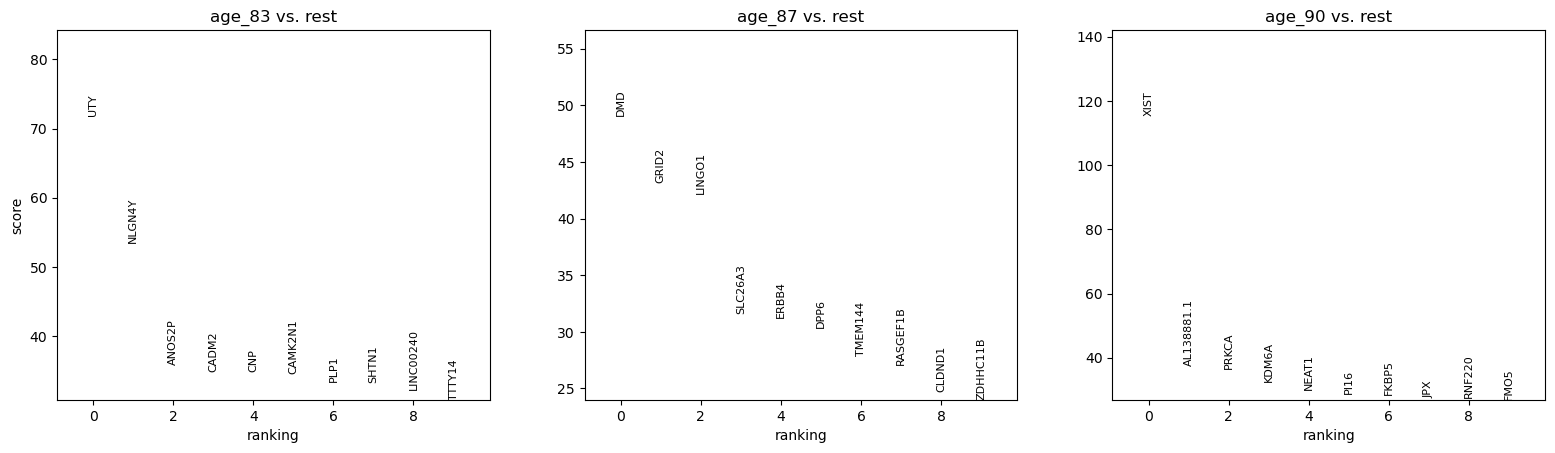

In [174]:
#Dataframe with ranked genes by Age
cluster_ranked_genes_Age = pd.DataFrame()
sc.tl.rank_genes_groups(adata, groupby="Age_range", use_raw=True)
sc.pl.rank_genes_groups(adata, n_genes=10,sharey=False)
cluster_ranked_genes_Age = sc.get.rank_genes_groups_df(adata, group= None)

In [56]:
#Ranked genes on the lowest age group

cluster_ranked_genes_Age[cluster_ranked_genes_Age['group'] == "age_83"]['names'].head(10)

0          UTY
1       NLGN4Y
2       ANOS2P
3        CADM2
4          CNP
5      CAMK2N1
6         PLP1
7        SHTN1
8    LINC00240
9       TTTY14
Name: names, dtype: object

In [57]:
#Ranked genes on the middle age group

cluster_ranked_genes_Age[cluster_ranked_genes_Age['group'] == "age_87"]['names'].head(10)

24180         DMD
24181       GRID2
24182      LINGO1
24183     SLC26A3
24184       ERBB4
24185        DPP6
24186     TMEM144
24187    RASGEF1B
24188      CLDND1
24189    ZDHHC11B
Name: names, dtype: object

In [58]:
#Ranked genes on the upper age group

cluster_ranked_genes_Age[cluster_ranked_genes_Age['group'] == "age_90"]['names'].head(10)

48360          XIST
48361    AL138881.1
48362         PRKCA
48363         KDM6A
48364         NEAT1
48365          PI16
48366         FKBP5
48367           JPX
48368        RNF220
48369          FMO5
Name: names, dtype: object

In [59]:
adata.write("Oligo_Corrected.h5ad")

## PAGA analysis

By quantifying the connectivity of partitions (groups, clusters) of the single-cell graph, partition-based graph abstraction (PAGA) generates a much simpler abstracted graph (PAGA graph) of partitions, in which edge weights represent confidence in the presence of connections. By tresholding this confidence in paga(), a much simpler representation of the manifold data is obtained, which is nonetheless faithful to the topology of the manifold.

The confidence should be interpreted as the ratio of the actual versus the expected value of connetions under the null model of randomly connecting partitions. We do not provide a p-value as this null model does not precisely capture what one would consider “connected” in real data, hence it strongly overestimates the expected value. See an extensive discussion of this in [Wolf19].

### Leiden 0.7

In [52]:
sc.tl.paga(adata, groups='leiden04')

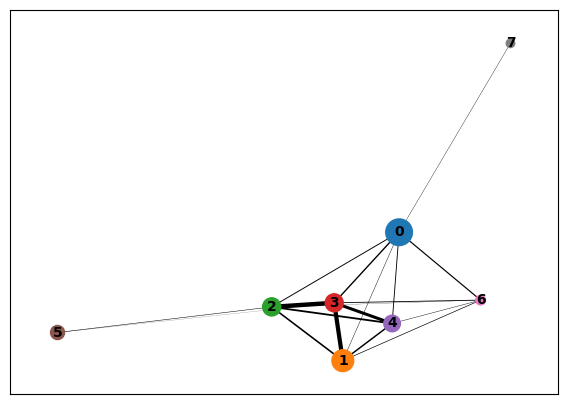

In [53]:
sc.pl.paga(adata, color=['leiden04'])

In [54]:
sc.pl.violin(adata, 'dpt_pseudotime', groupby = 'leiden04', log = True)

KeyError: "Could not find keys '['dpt_pseudotime']' in columns of `adata.obs` or in adata.raw.var_names."

### Diagnosis

In [55]:
# cluster_ranked_genes_Diag[cluster_ranked_genes_Diag['group'] == "Control"]['names'].head(10)
cluster_ranked_genes_Diag[cluster_ranked_genes_Diag['group'] == "AD"]['names'].head(10)

0        NEAT1
1     CNTNAP3B
2        ERBIN
3       SAMD4A
4       ATP1B3
5      COLEC12
6          HGF
7        HSPH1
8        NPAS2
9    CNTNAP3P2
Name: names, dtype: object

In [78]:
#So, you dont differentiate based on the groups!

#sc.tl.paga(adata, groups='Diagnosis')

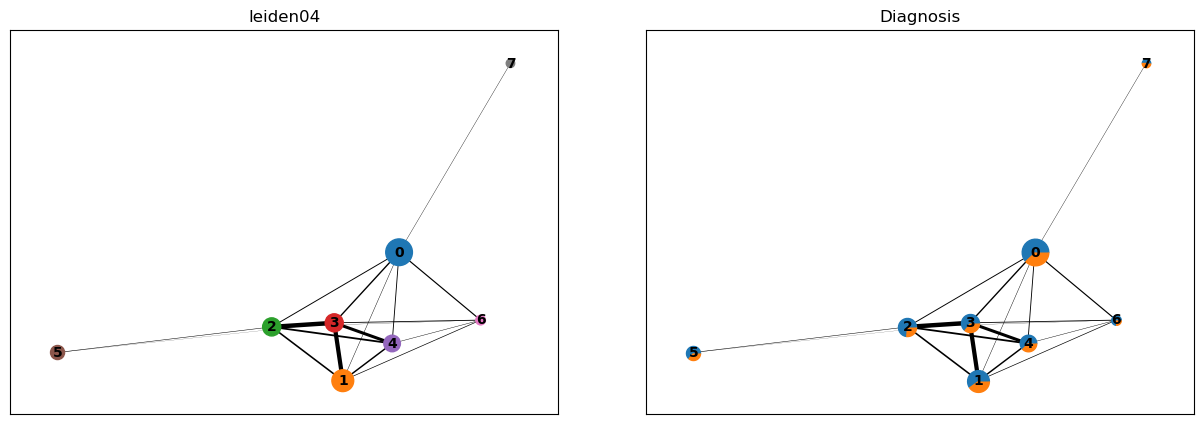

In [56]:
sc.pl.paga(adata, color=['leiden04', 'Diagnosis'])

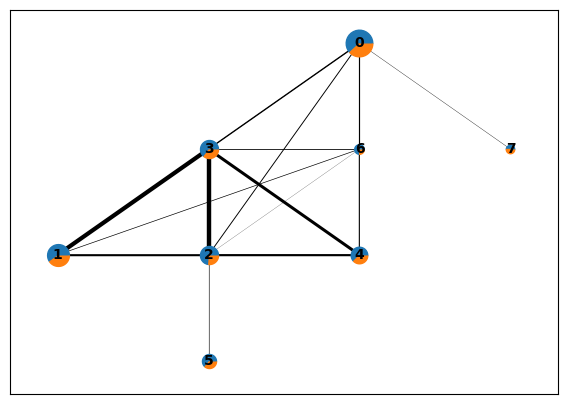

In [58]:
sc.pl.paga(adata, color=['Diagnosis'], layout="rt", root=0)

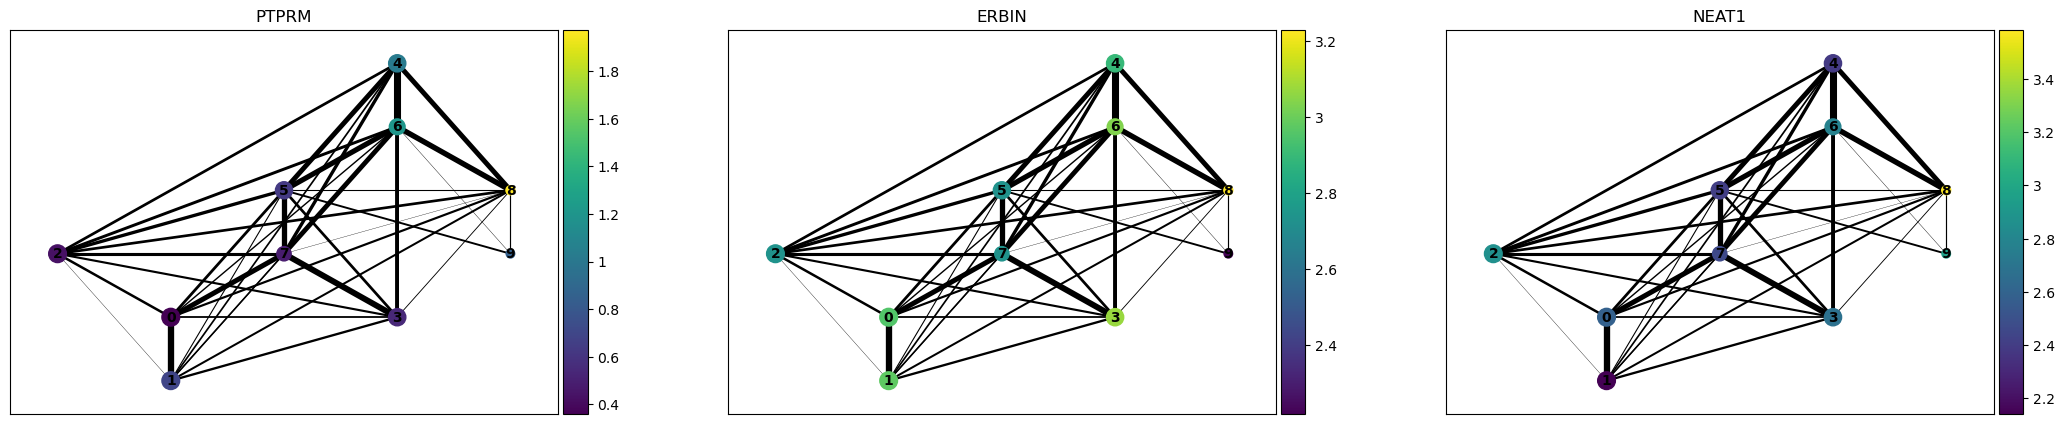

In [83]:
#3 AD

sc.pl.paga(adata, color=['PTPRM', 'ERBIN', 'NEAT1'], threshold = 0.03, layout="rt", root=4)

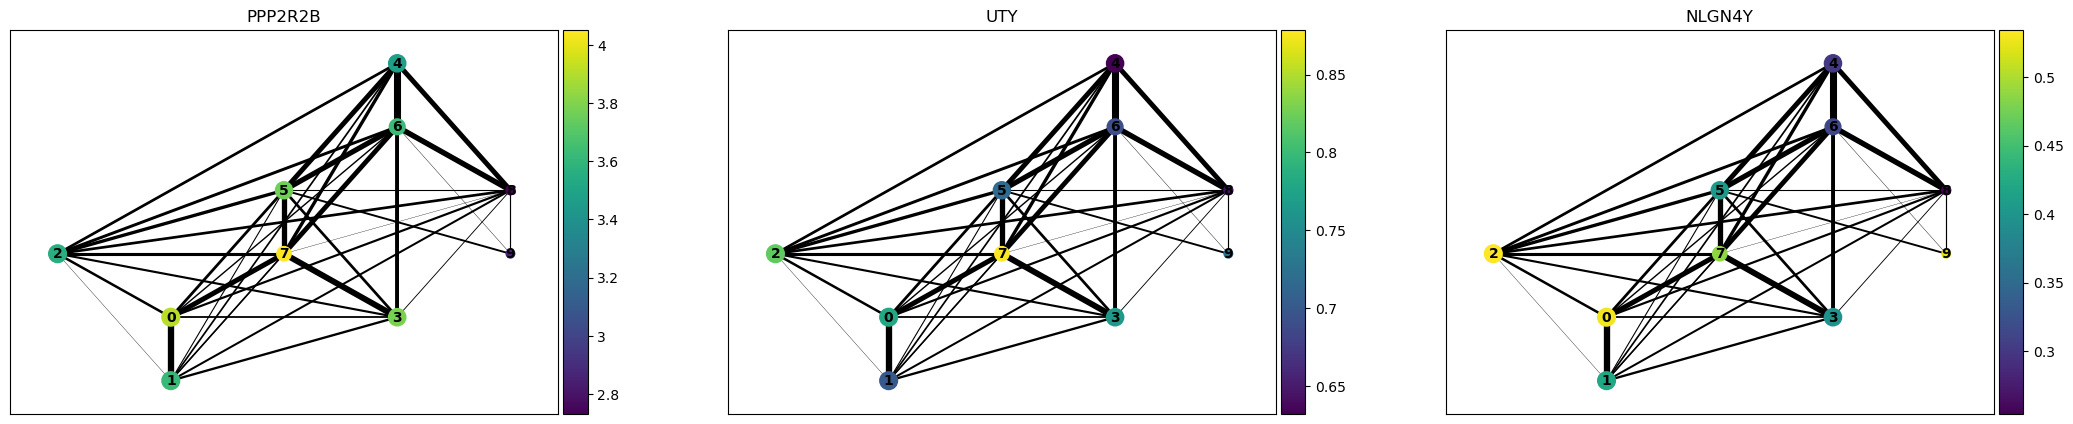

In [84]:
#3 control genes

sc.pl.paga(adata, color=['PPP2R2B', 'UTY', 'NLGN4Y'], threshold = 0.03, layout="rt", root=4)

##### Recomputing the embedding using PAGA-initialization


In [59]:
sc.tl.draw_graph(adata, init_pos='paga')

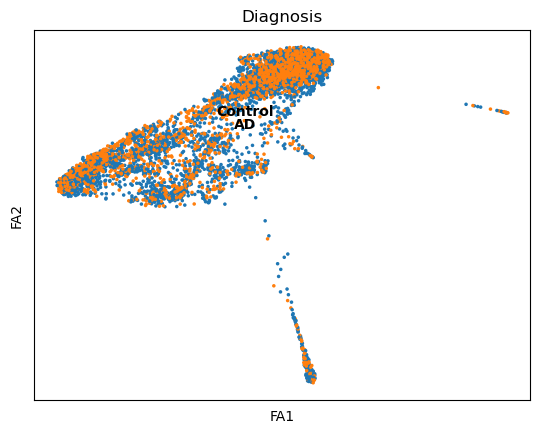

In [60]:
sc.pl.draw_graph(adata, color=['Diagnosis'], legend_loc='on data')

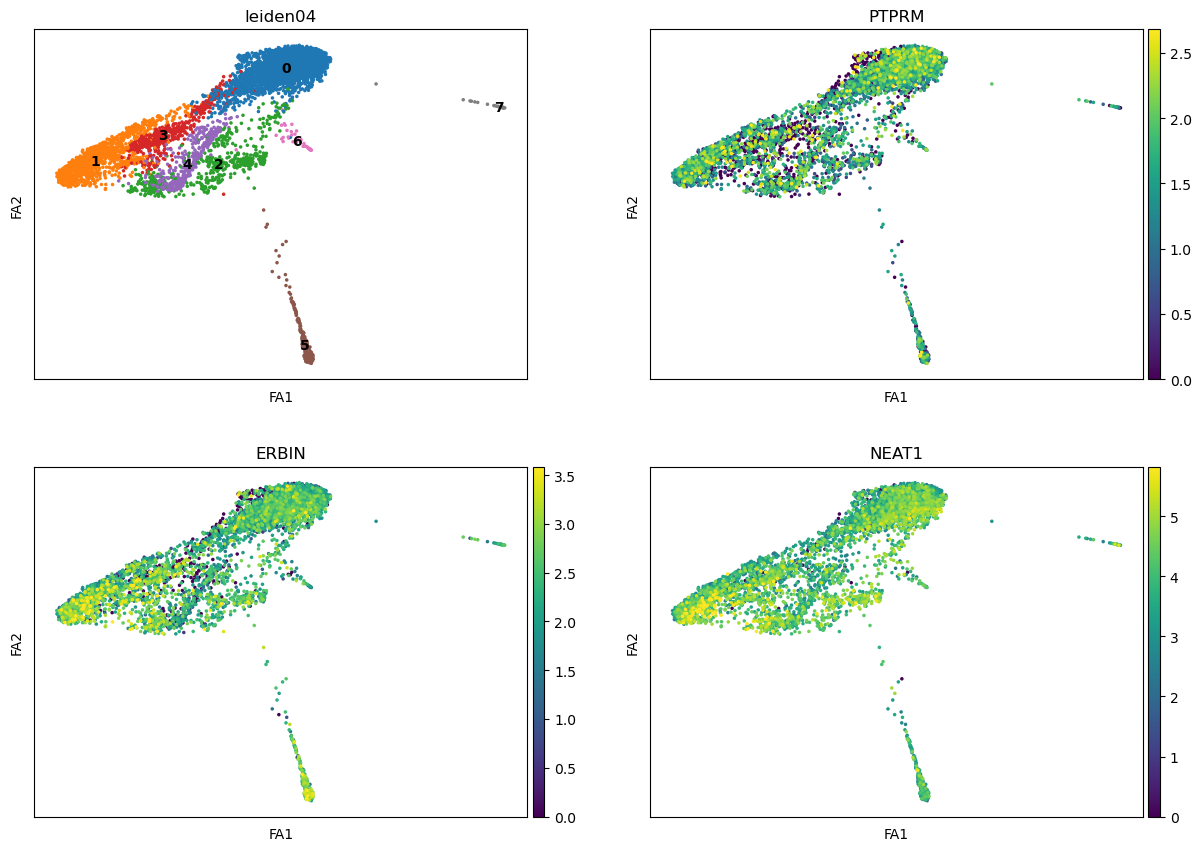

In [63]:
#AD
sc.pl.draw_graph(adata, color=['leiden04', 'PTPRM', 'ERBIN', 'NEAT1'], legend_loc='on data', ncols=2, vmin = 'p1.5', vmax = 'p99')

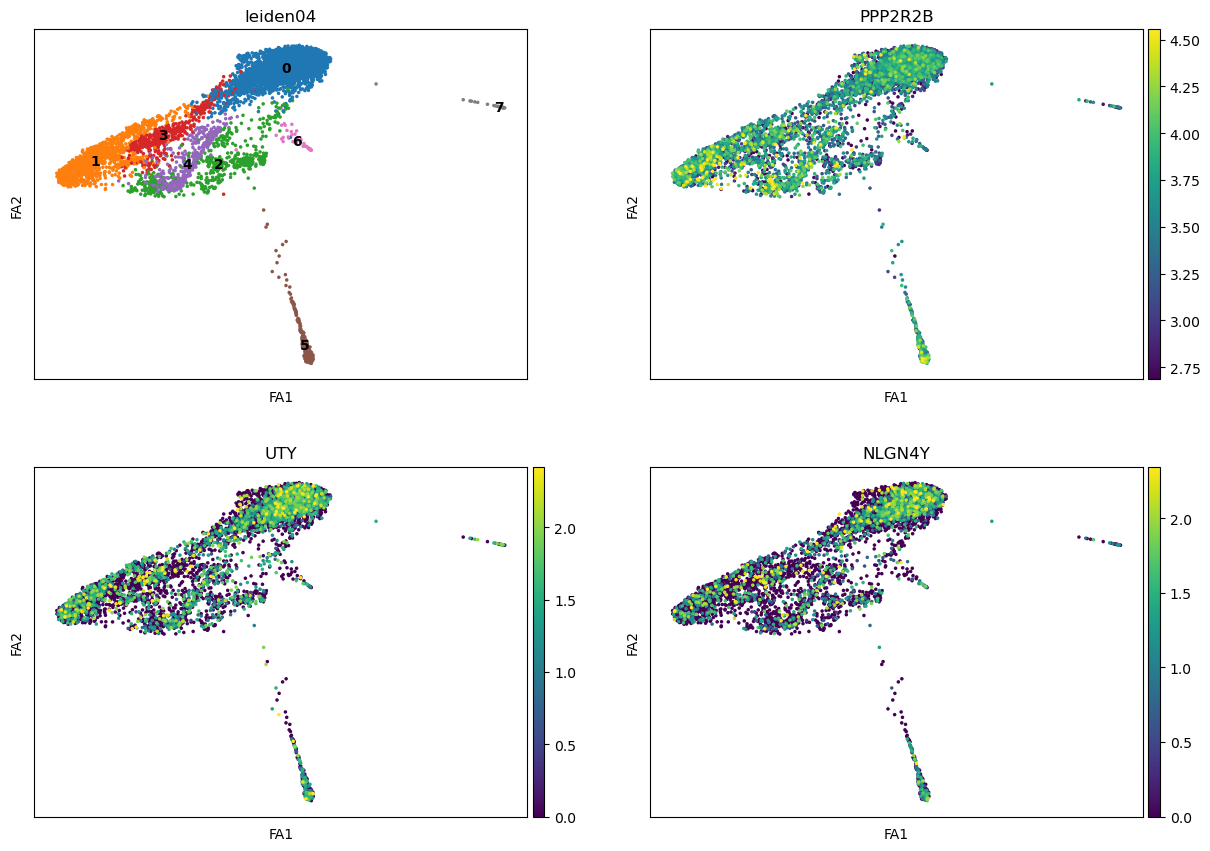

In [62]:
#CONTROL
sc.pl.draw_graph(adata, color=['leiden04', 'PPP2R2B', 'UTY', 'NLGN4Y'], legend_loc='on data', ncols=2, vmin = 'p10', vmax = 'p99')


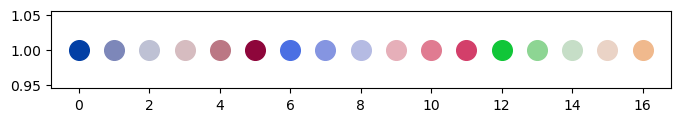

In [64]:
#Adjust the color scheme

plt.figure(figsize=(8, 1))
for i in range(17):
    plt.scatter(i, 1, c=sc.pl.palettes.zeileis_28[i], s=200)
plt.show()

In [ ]:
# Gives Errors, have to look into

#zeileis_colors = np.array(sc.pl.palettes.zeileis_28)
# new_colors = np.array(adata.uns['leiden04_diagnosis'])

##### Reconstructing gene changes along PAGA paths for a given set of genes


In [74]:
#Choose a root cell for diffusion pseudotime.


#AD  ---> Why this step?
adata.uns['iroot'] = np.flatnonzero(adata.obs['Diagnosis']  == 'AD')[0]

In [75]:
sc.tl.dpt(adata)

In [76]:
gene_names = ['PTPRM', 'ERBIN', 'NEAT1',                      # AD
              'PPP2R2B', 'UTY', 'NLGN4Y']                    # Control

/data/leuven/338/vsc33876/miniconda3/envs/python38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


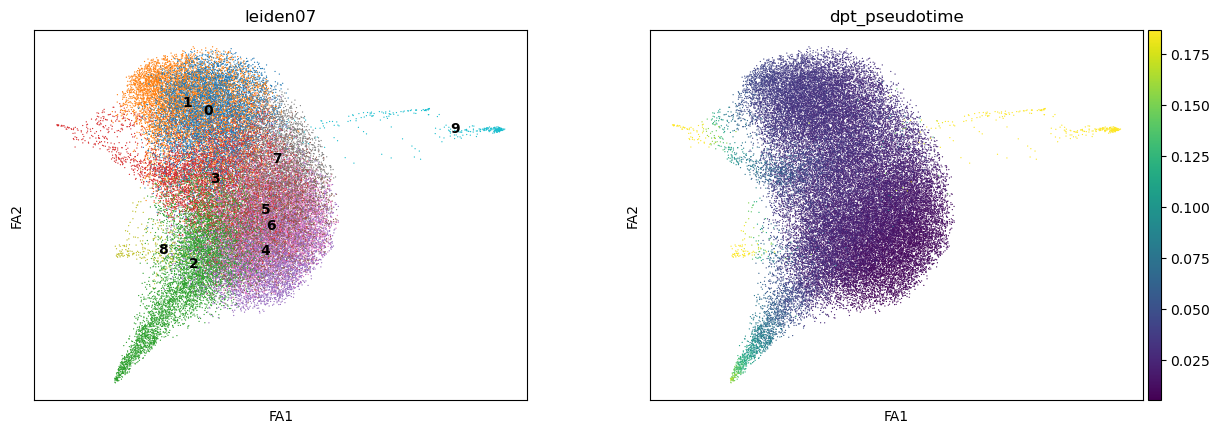

In [100]:
#Use the fulll data for visualization:

sc.pl.draw_graph(adata, color=['leiden07', 'dpt_pseudotime'], legend_loc='on data',vmin = 'p1.5', vmax = 'p99')

/data/leuven/338/vsc33876/miniconda3/envs/python38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/data/leuven/338/vsc33876/miniconda3/envs/python38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


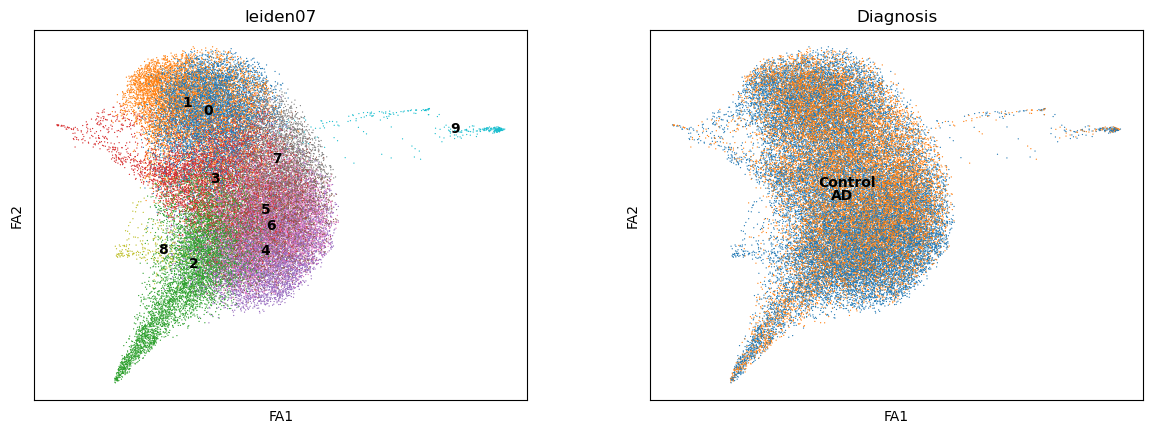

In [78]:
sc.pl.draw_graph(adata, color=['leiden07', 'Diagnosis'], legend_loc='on data')

In [90]:
#AD is blue, C is orange

paths = [('AD', [1, 4, 8, 2]),
         ('Control', [0,3,5,6,7])]

/data/leuven/338/vsc33876/miniconda3/envs/python38/lib/python3.8/site-packages/scanpy/plotting/_tools/paga.py:1229: UserWarning: FixedFormatter should only be used together with FixedLocator
  groups_axis.set_yticklabels(['', xlabel, ''], fontsize=ytick_fontsize)
/data/leuven/338/vsc33876/miniconda3/envs/python38/lib/python3.8/site-packages/scanpy/plotting/_tools/paga.py:1276: UserWarning: FixedFormatter should only be used together with FixedLocator
  anno_axis.set_yticklabels(['', anno, ''], fontsize=ytick_fontsize)


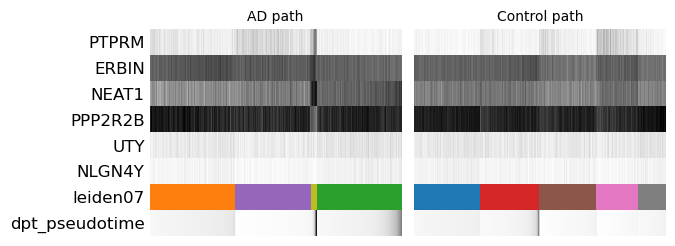

In [92]:
#Look at ordering according to prseudotime

_, axs = plt.subplots(ncols=2, figsize=(6, 2.5), gridspec_kw={'wspace': 0.05, 'left': 0.12})
plt.subplots_adjust(left=0.05, right=0.98, top=0.82, bottom=0.2)
for ipath, (descr, path) in enumerate(paths):
    _, data = sc.pl.paga_path(
        adata, path, gene_names,   #can add more genes
        show_node_names=False,
        ax=axs[ipath],
        ytick_fontsize=12,
        left_margin=0.15,
        n_avg=50,
        annotations=['dpt_pseudotime'],
        show_yticks=True if ipath==0 else False,
        show_colorbar=False,
        color_map='Greys',
        groups_key='leiden07',
        color_maps_annotations={'distance': 'viridis'},
        title='{} path'.format(descr),
        return_data=True,
        show=False)
#    data.to_csv('./write/paga_path_{}.csv'.format(descr))
#pl.savefig('./figures/paga_path_paul15.pdf')
plt.show()

### Sex

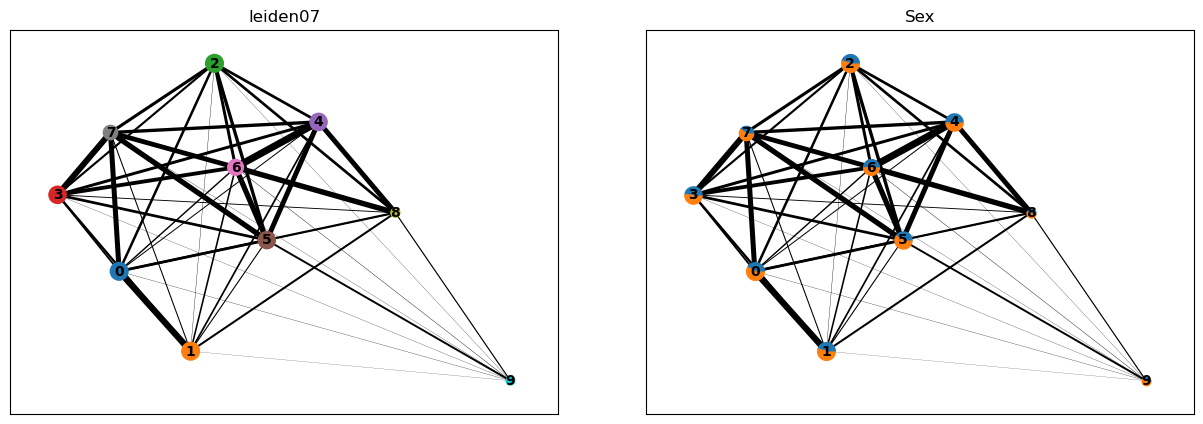

In [93]:
sc.pl.paga(adata, color=['leiden07', 'Sex'])

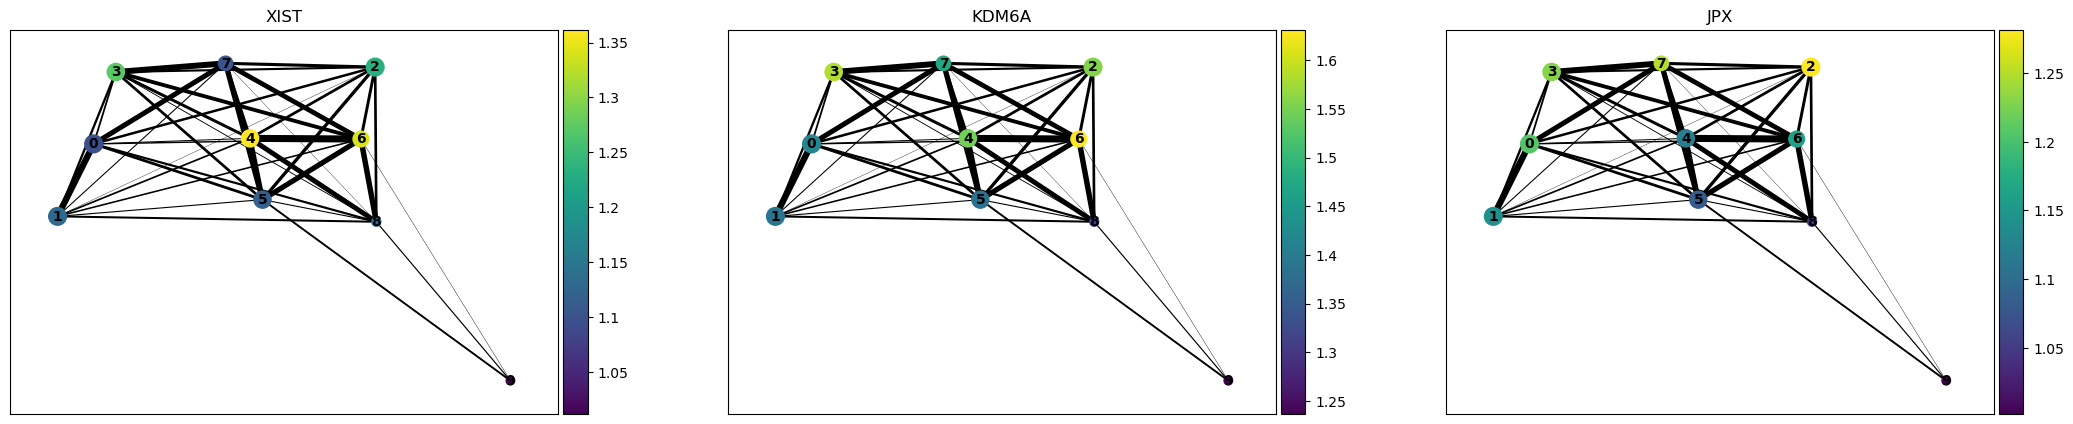

In [94]:
#3 Female

sc.pl.paga(adata, color=['XIST', 'KDM6A', 'JPX'], threshold = 0.03)

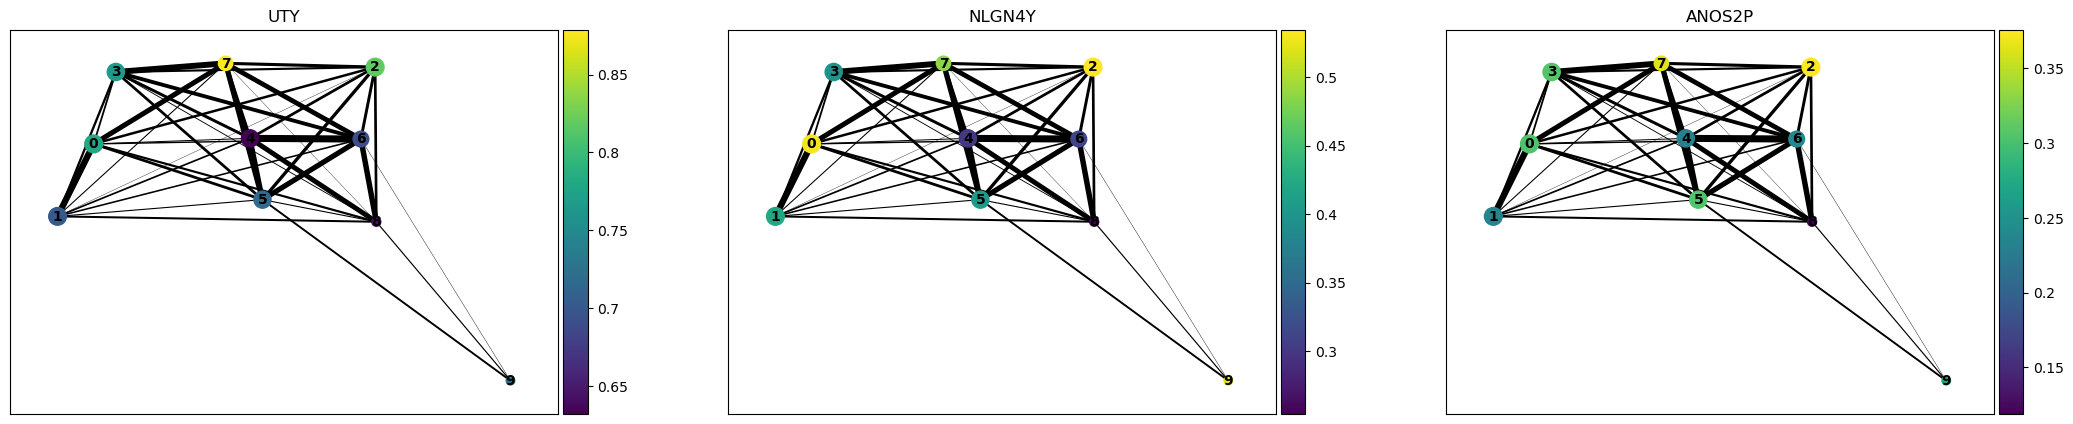

In [95]:
#3 Male

sc.pl.paga(adata, color=['UTY', 'NLGN4Y', 'ANOS2P'], threshold = 0.03)

##### Recomputing the embedding using PAGA-initialization


/data/leuven/338/vsc33876/miniconda3/envs/python38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


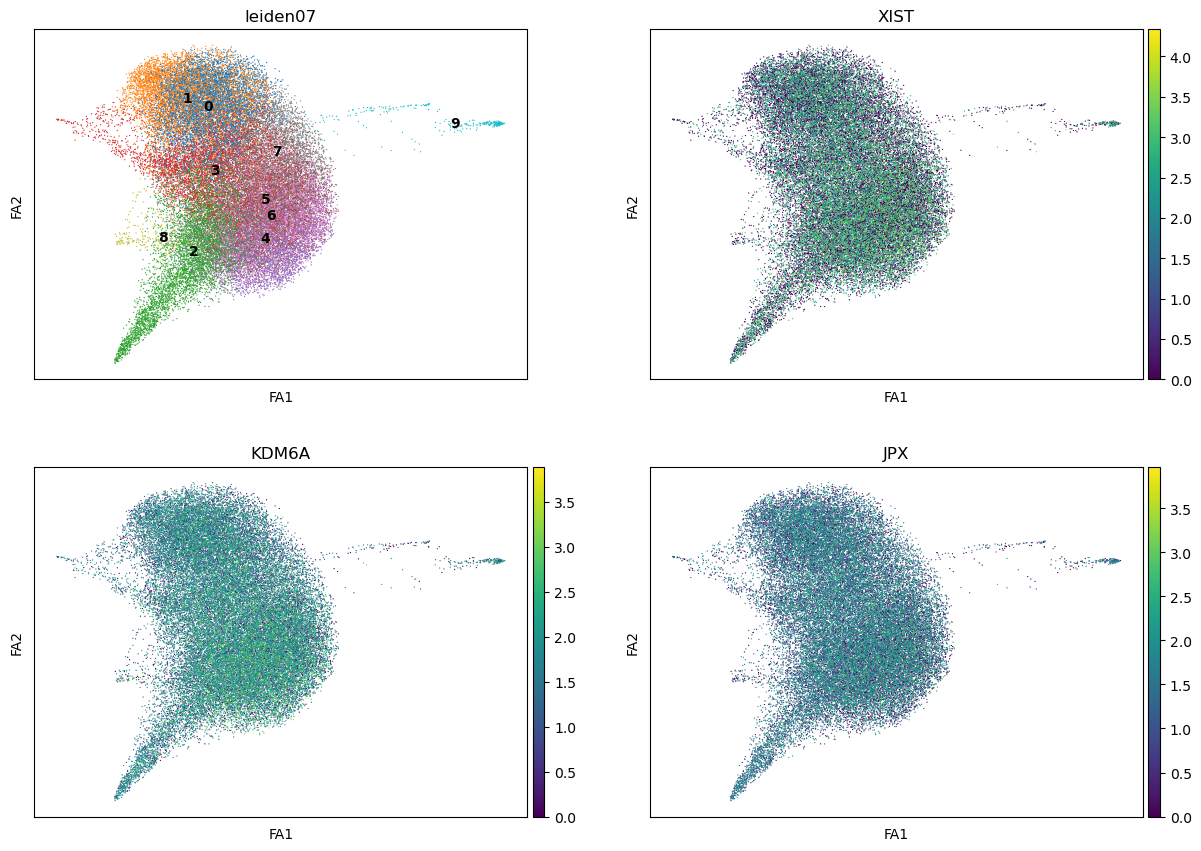

In [96]:
#Female
sc.pl.draw_graph(adata, color=['leiden07', 'XIST', 'KDM6A', 'JPX'], legend_loc='on data', ncols=2)

/data/leuven/338/vsc33876/miniconda3/envs/python38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


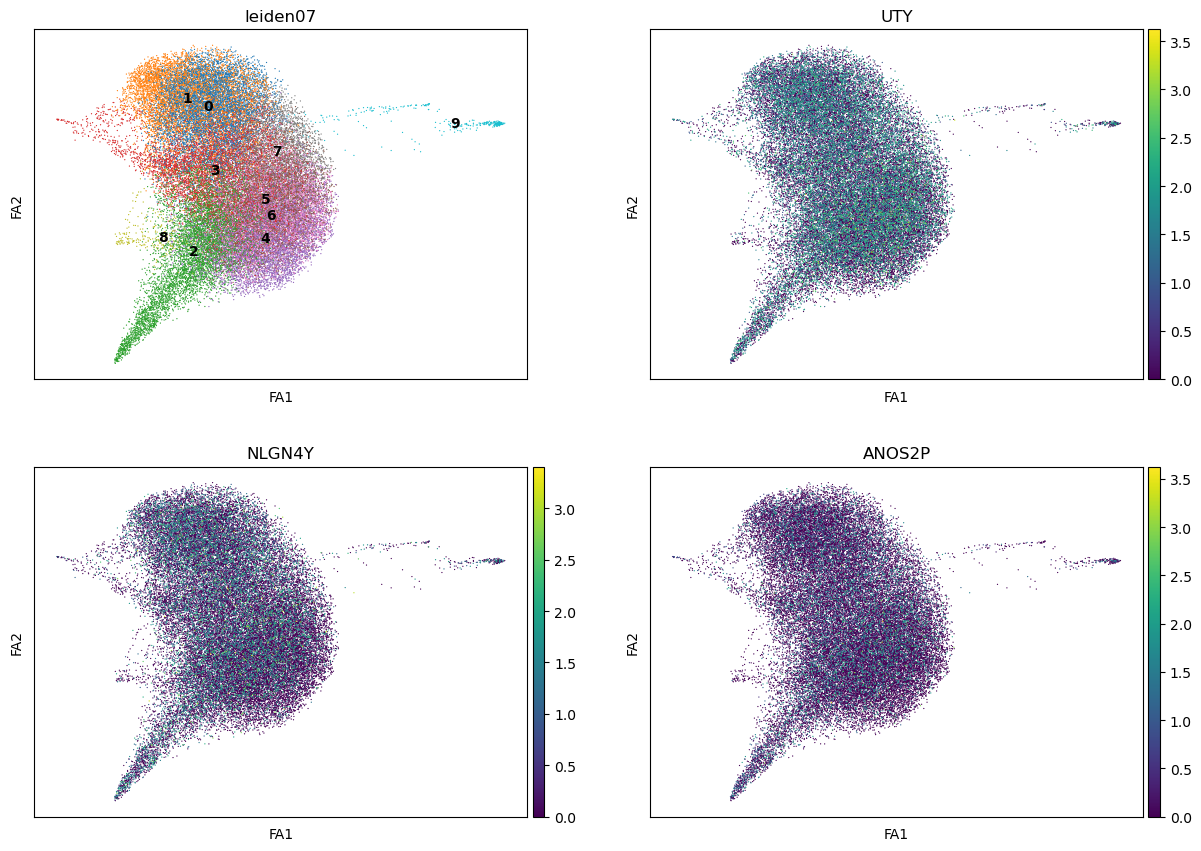

In [97]:
#gM
sc.pl.draw_graph(adata, color=['leiden07', 'UTY', 'NLGN4Y', 'ANOS2P'], legend_loc='on data', ncols=2)

##### Reconstructing gene changes along PAGA paths for a given set of genes


In [76]:
#Choose a root cell for diffusion pseudotime.

#F  ---> Why this step?

adata.uns['iroot'] = np.flatnonzero(adata.obs['Sex']  == 'F')[0]

In [77]:
sc.tl.dpt(adata)

In [78]:
gene_names = ['XIST', 'KDM6A', 'JPX',                      # F
              'UTY', 'NLGN4Y', 'ANOS2P']                    # M

/data/leuven/338/vsc33876/miniconda3/envs/python38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


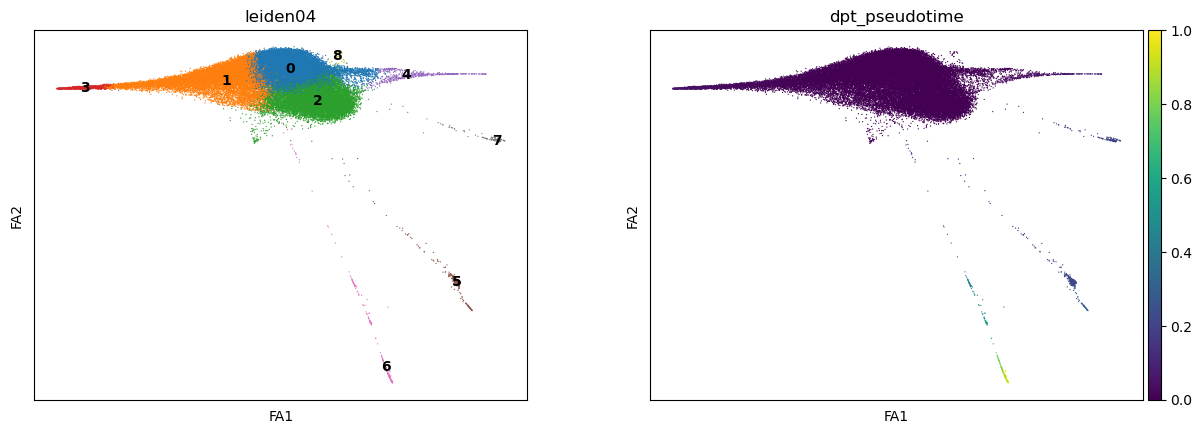

In [79]:
#Check what is pseudotime!

#Use the fulll data for visualization:

sc.pl.draw_graph(adata, color=['leiden04', 'dpt_pseudotime'], legend_loc='on data')

/data/leuven/338/vsc33876/miniconda3/envs/python38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/data/leuven/338/vsc33876/miniconda3/envs/python38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


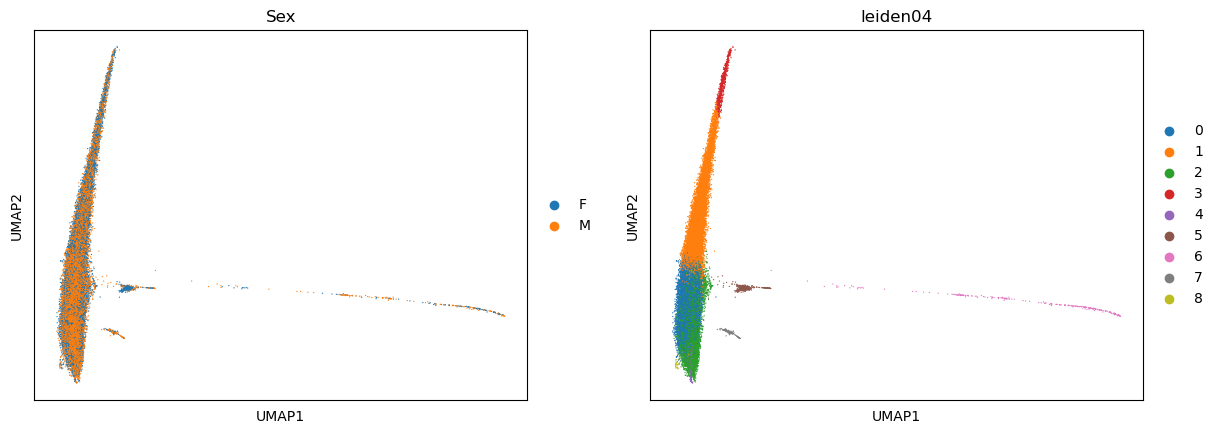

In [80]:
sc.pl.umap(adata, color= ['Sex', 'leiden04'], ncols = 2)

In [170]:
paths = [('Female', [1, 11, 3, 0, 14, 9, 17, 13]),
         ('Male', [2, 4, 5, 6, 7, 8, 10, 12, 15, 16])]

/data/leuven/338/vsc33876/miniconda3/envs/python38/lib/python3.8/site-packages/scanpy/plotting/_tools/paga.py:1229: UserWarning: FixedFormatter should only be used together with FixedLocator
  groups_axis.set_yticklabels(['', xlabel, ''], fontsize=ytick_fontsize)
/data/leuven/338/vsc33876/miniconda3/envs/python38/lib/python3.8/site-packages/scanpy/plotting/_tools/paga.py:1276: UserWarning: FixedFormatter should only be used together with FixedLocator
  anno_axis.set_yticklabels(['', anno, ''], fontsize=ytick_fontsize)


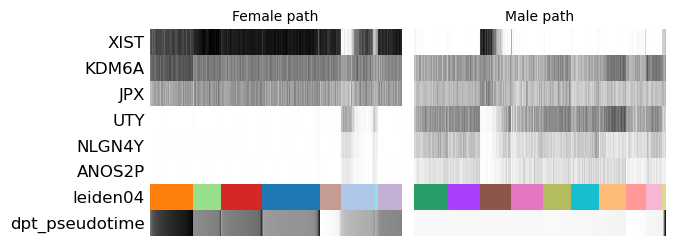

In [171]:
_, axs = plt.subplots(ncols=2, figsize=(6, 2.5), gridspec_kw={'wspace': 0.05, 'left': 0.12})
plt.subplots_adjust(left=0.05, right=0.98, top=0.82, bottom=0.2)
for ipath, (descr, path) in enumerate(paths):
    _, data = sc.pl.paga_path(
        adata, path, gene_names,   #can add more genes
        show_node_names=False,
        ax=axs[ipath],
        ytick_fontsize=12,
        left_margin=0.15,
        n_avg=50,
        annotations=['dpt_pseudotime'],
        show_yticks=True if ipath==0 else False,
        show_colorbar=False,
        color_map='Greys',
        groups_key='leiden04',
        color_maps_annotations={'distance': 'viridis'},
        title='{} path'.format(descr),
        return_data=True,
        show=False)
#    data.to_csv('./write/paga_path_{}.csv'.format(descr))
#pl.savefig('./figures/paga_path_paul15.pdf')
plt.show()

### Age

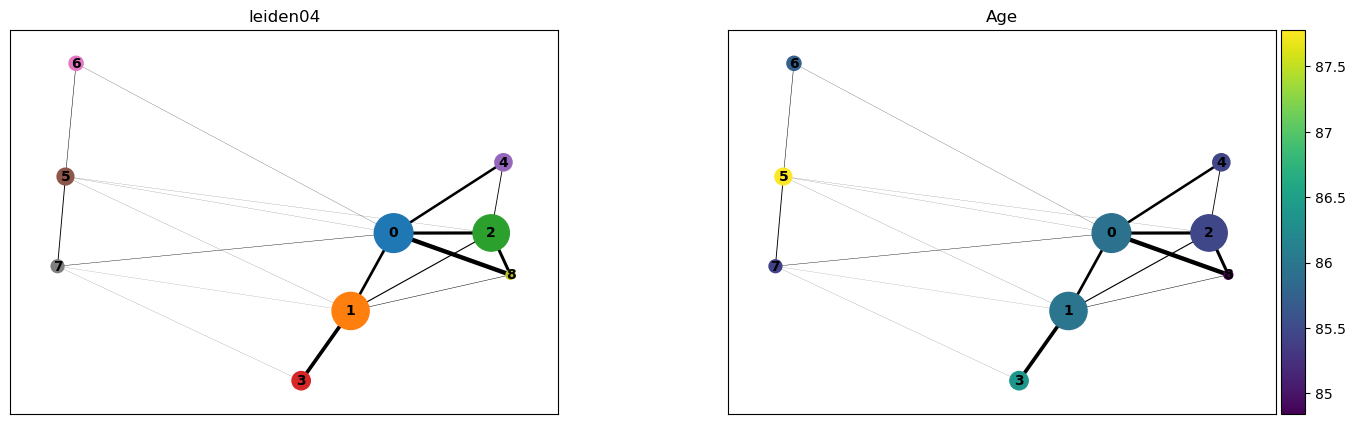

In [81]:
sc.pl.paga(adata, color=['leiden04', 'Age'])

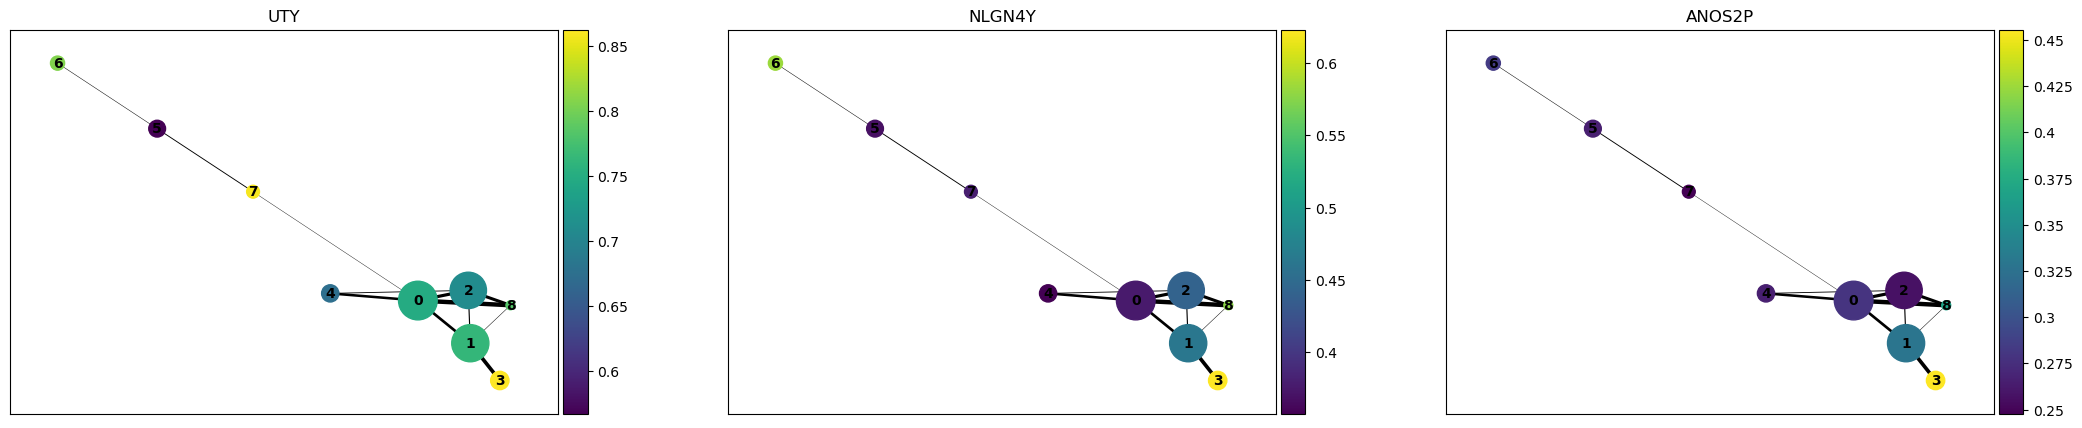

In [82]:
#3 Age gY (group young)

sc.pl.paga(adata, color=['UTY', 'NLGN4Y', 'ANOS2P'], threshold = 0.03)

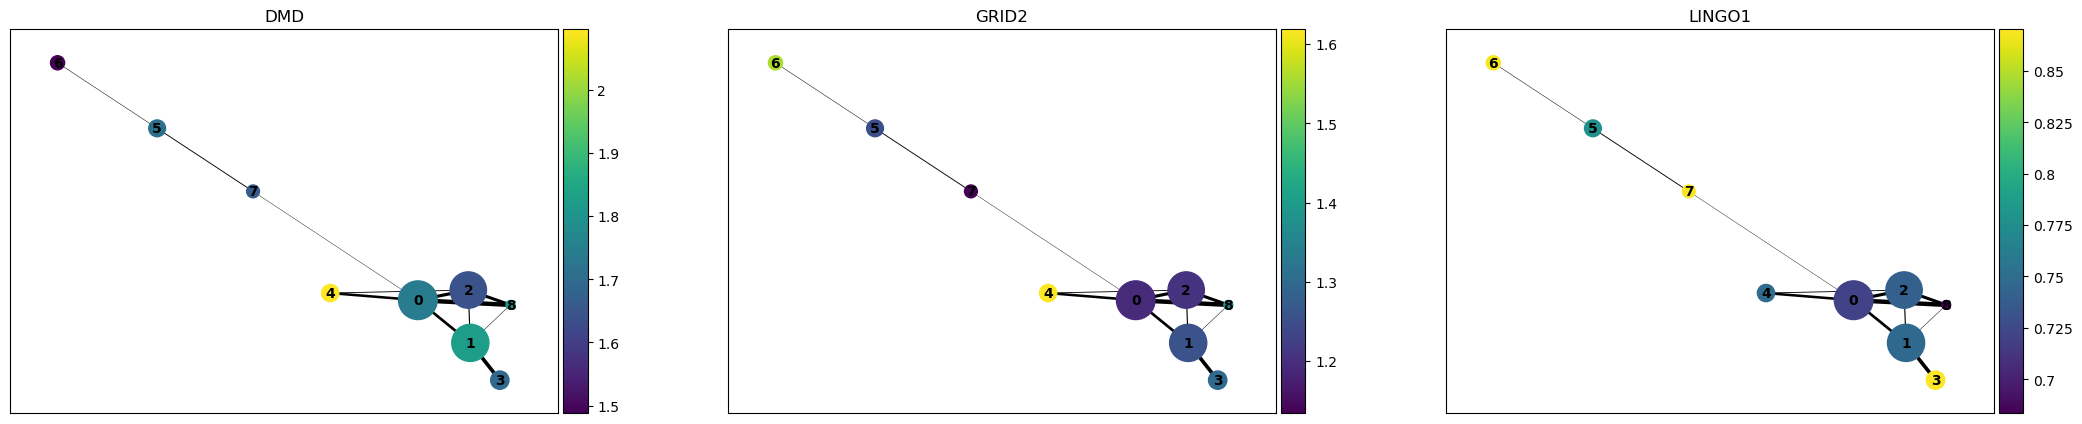

In [85]:
#3 Age gM (group medium)

sc.pl.paga(adata, color=['DMD', 'GRID2', 'LINGO1'], threshold = 0.03)

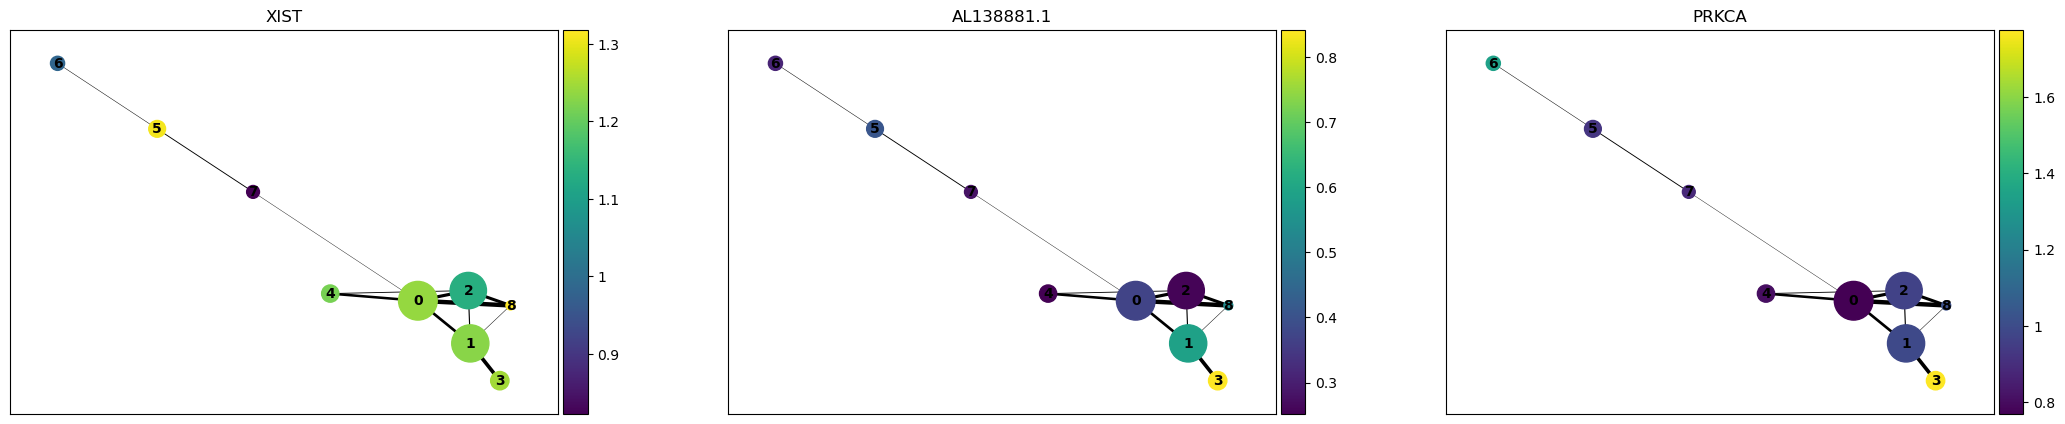

In [86]:
#3 Age gO (group old)

sc.pl.paga(adata, color=['XIST', 'AL138881.1', 'PRKCA'], threshold = 0.03)

##### Recomputing the embedding using PAGA-initialization


/data/leuven/338/vsc33876/miniconda3/envs/python38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


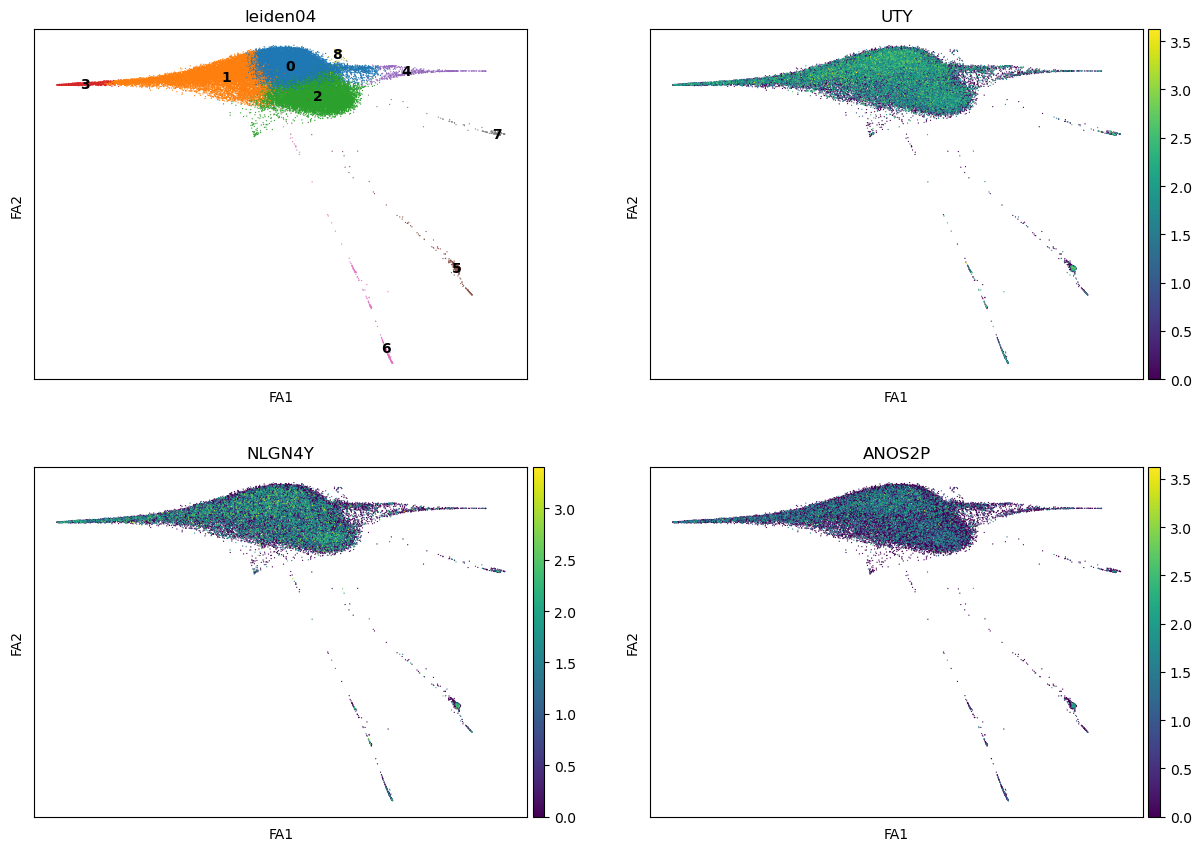

In [87]:
#gY
sc.pl.draw_graph(adata, color=['leiden04', 'UTY', 'NLGN4Y', 'ANOS2P'], legend_loc='on data', ncols=2)

/data/leuven/338/vsc33876/miniconda3/envs/python38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


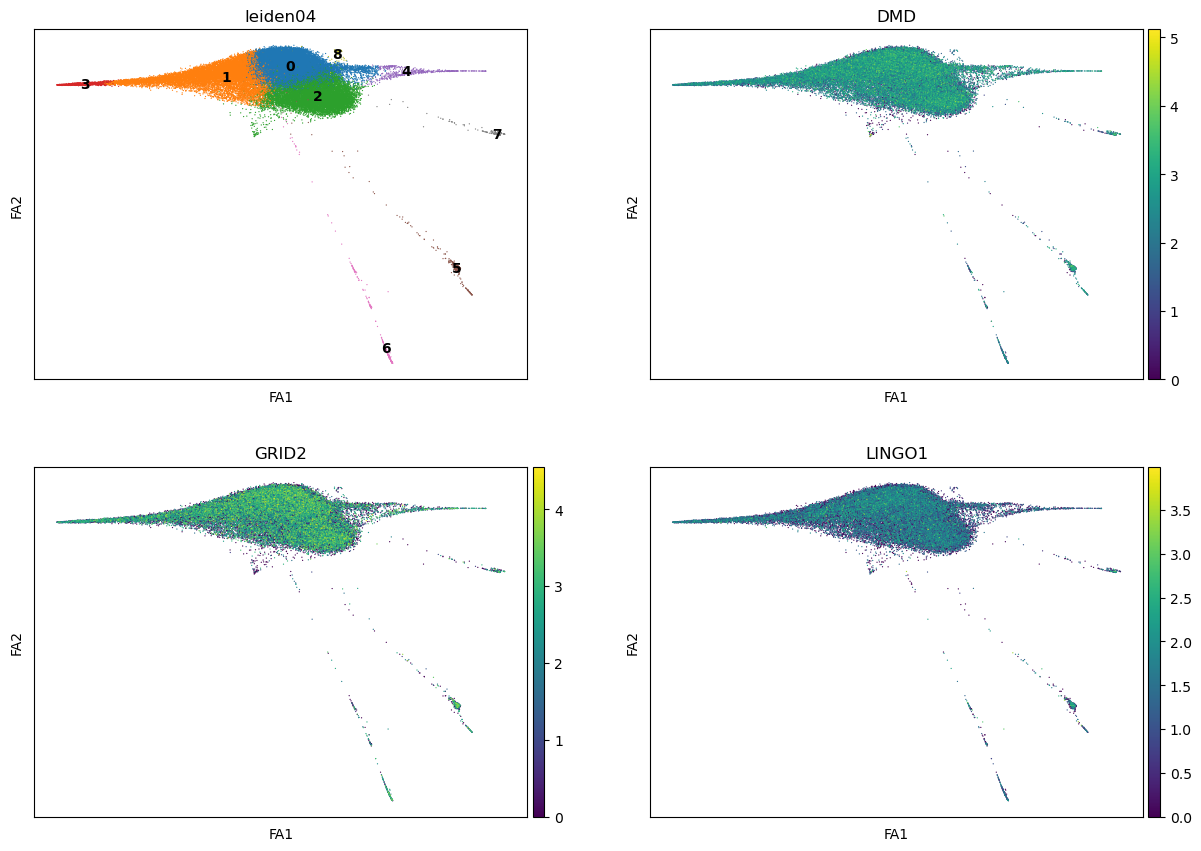

In [88]:
#gM
sc.pl.draw_graph(adata, color=['leiden04', 'DMD', 'GRID2', 'LINGO1'], legend_loc='on data', ncols=2)

/data/leuven/338/vsc33876/miniconda3/envs/python38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


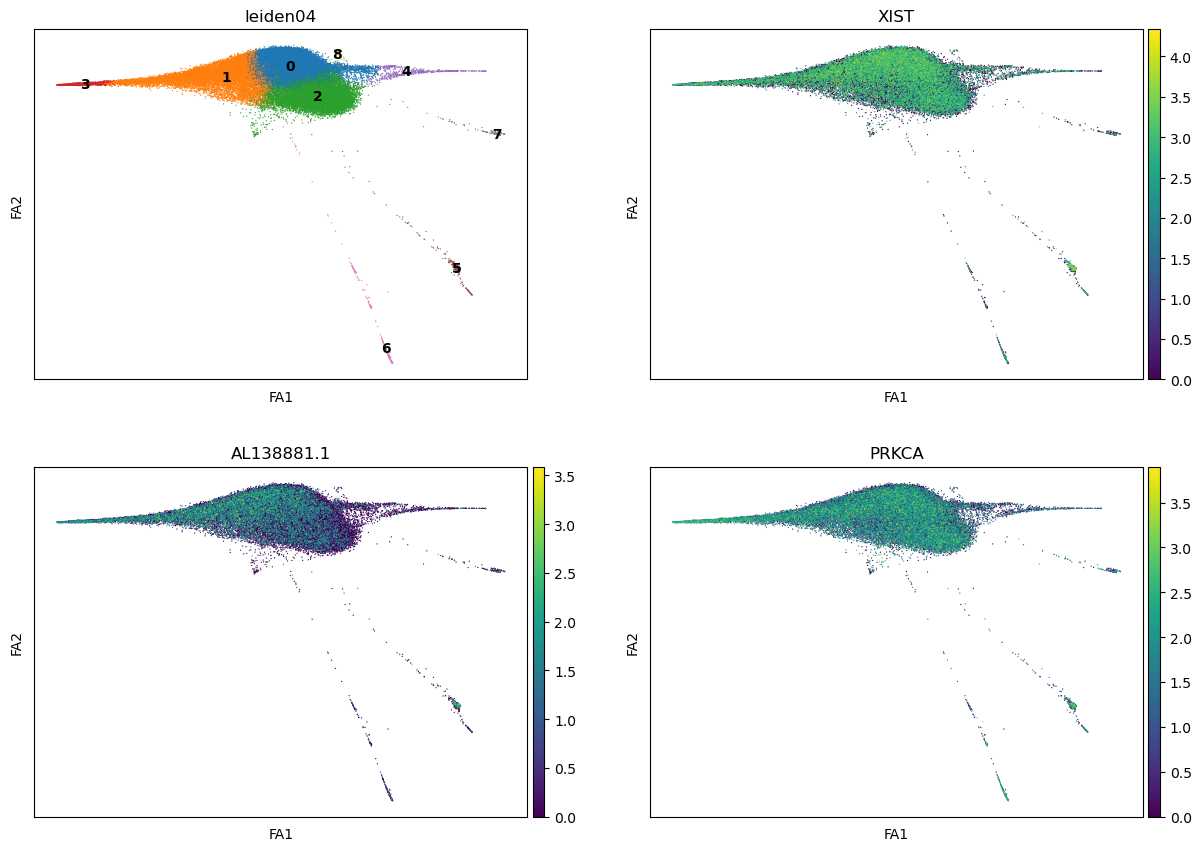

In [89]:
#gO
sc.pl.draw_graph(adata, color=['leiden04', 'XIST', 'AL138881.1', 'PRKCA'], legend_loc='on data', ncols=2)

##### Reconstructing gene changes along PAGA paths for a given set of genes


In [91]:
#Choose a root cell for diffusion pseudotime.

#gO  ---> Why this step?

adata.uns['iroot'] = np.flatnonzero(adata.obs['Age_range']  == 'age_90')[0]

KeyError: 'Age_range'

In [92]:
sc.tl.dpt(adata)

In [93]:
gene_names = ['UTY', 'NLGN4Y', 'ANOS2P',                      # young
              'DMD', 'GRID2', 'LINGO1',                       # medium
             'XIST', 'AL138881.1', 'PRKCA']                    # old

/data/leuven/338/vsc33876/miniconda3/envs/python38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


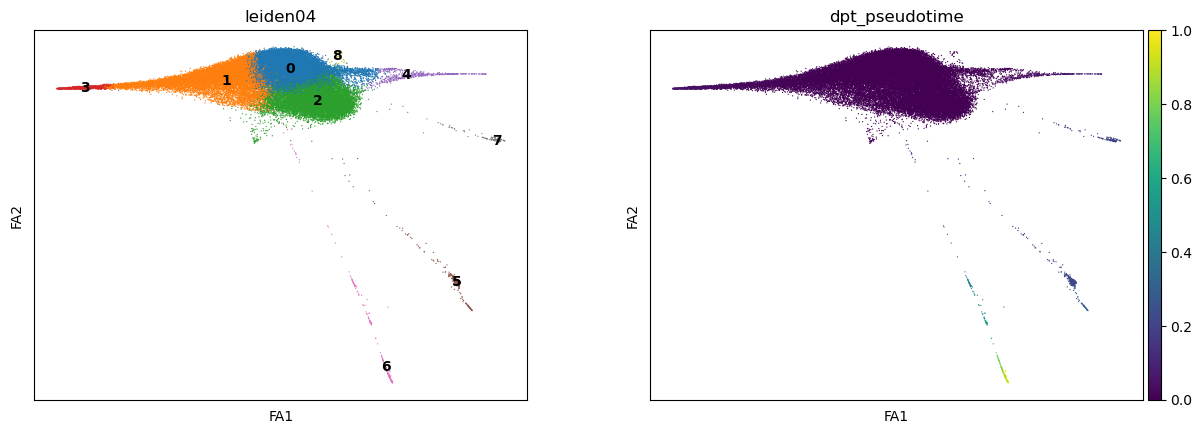

In [94]:
#Check what is pseudotime!

#Use the fulll data for visualization:

sc.pl.draw_graph(adata, color=['leiden04', 'dpt_pseudotime'], legend_loc='on data')

In [163]:
paths = [('age_90', [0, 1, 3, 7, 8, 11, 14, 16, 17 ]),
         ('age_83', [2, 4, 6, 9, 12, 13,  15 ]),
        ('age_87', [5, 10])]

/data/leuven/338/vsc33876/miniconda3/envs/python38/lib/python3.8/site-packages/scanpy/plotting/_tools/paga.py:1229: UserWarning: FixedFormatter should only be used together with FixedLocator
  groups_axis.set_yticklabels(['', xlabel, ''], fontsize=ytick_fontsize)
/data/leuven/338/vsc33876/miniconda3/envs/python38/lib/python3.8/site-packages/scanpy/plotting/_tools/paga.py:1276: UserWarning: FixedFormatter should only be used together with FixedLocator
  anno_axis.set_yticklabels(['', anno, ''], fontsize=ytick_fontsize)


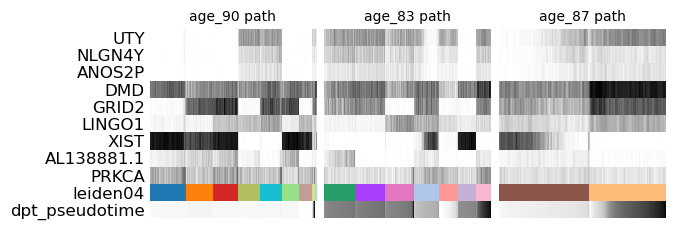

In [164]:
_, axs = plt.subplots(ncols=3, figsize=(6, 2.5), gridspec_kw={'wspace': 0.05, 'left': 0.12})
plt.subplots_adjust(left=0.05, right=0.98, top=0.82, bottom=0.2)
for ipath, (descr, path) in enumerate(paths):
    _, data = sc.pl.paga_path(
        adata, path, gene_names,   #can add more genes
        show_node_names=False,
        ax=axs[ipath],
        ytick_fontsize=12,
        left_margin=0.15,
        n_avg=50,
        annotations=['dpt_pseudotime'],
        show_yticks=True if ipath==0 else False,
        show_colorbar=False,
        color_map='Greys',
        groups_key='leiden04',
        color_maps_annotations={'distance': 'viridis'},
        title='{} path'.format(descr),
        return_data=True,
        show=False)
#    data.to_csv('./write/paga_path_{}.csv'.format(descr))
#pl.savefig('./figures/paga_path_paul15.pdf')
plt.show()

## GOrilla Analysis

In [ ]:
#Men
http://cbl-gorilla.cs.technion.ac.il/GOrilla/rt23jj7b/GOResults.html

In [ ]:
#Women
http://cbl-gorilla.cs.technion.ac.il/GOrilla/oe3m1631/GOResults.html

In [ ]:
#AD
http://cbl-gorilla.cs.technion.ac.il/GOrilla/kkacagh5/GOResults.html

In [ ]:
#Control
http://cbl-gorilla.cs.technion.ac.il/GOrilla/kzm8fic1/GOResults.html

# Save file

In [95]:
adata.write("Oligo_Corrected.h5ad")

In [5]:
# adata = sc.read_h5ad('Oligo.h5ad')

In [3]:
# adata = sc.read_h5ad('Microglia_SCVI.h5ad')